In [151]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import matplotlib.pylab as pl
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
mpl.rcParams['figure.dpi']=300

plt.rcParams.update({
    "text.usetex": True,
    "font.size" : 16,
    "font.family": "serif",
    "font.serif": 'cm10',
    'savefig.bbox' : 'tight'})

from tqdm import tqdm
from utils.ASA import get_params,ASA_propagator,ASA_sources
from utils.FFT import custom_fft2,custom_ifft2


/var/folders/cw/5xff940s6559c90nyhzx9s9m0000gn/T/ipykernel_1063/3018408931.py:7: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']


The provided python script ASA.py propagates a uniform pressure distribution of a square aperture with dimension $15\times15 \lambda^2$, excitation frequency $f_x = 3$ MHz, and positioned at $z_0 = 0$ to a chosen range $z = 8$ cm and plots the result.

## Q.1.  Discontinuous aperture

Run the script ASA.m. Do the plots look as expected? Explain what you observe and why. (Hint: If you for some reason are unsure about what to answer, continue on the following tasks and return to this later).

In [152]:
# We get the parameters
config = get_params()
# We define the aperture radius
radius = 15*config['lambda']
# We compute the propagation matrix
prop = ASA_propagator(config=config,z=0.08)
# We generate the wave field of a squared source
U_0 = ASA_sources(config=config,type='square',r=radius)
# We propagate the previous wave field
U = custom_ifft2(custom_fft2(U_0)*prop)

/Users/thomasaussagues/SynologyDrive/Drive/UiO/Signal Array Processing/Exercices/Mandatory1/Jupyter/utils/ASA.py:47: RuntimeWarning: invalid value encountered in sqrt
  prop = np.exp(1j * 2 * np.pi * z * np.sqrt(1 - uSq - vSq) / config['lambda'] )


Here, we first plot the wave field in the aperture (e.g for $z=0$).

/var/folders/cw/5xff940s6559c90nyhzx9s9m0000gn/T/ipykernel_1063/586188857.py:2: RuntimeWarning: divide by zero encountered in log10
  abs_U_0_log = 10*np.log10(np.abs(U_0))


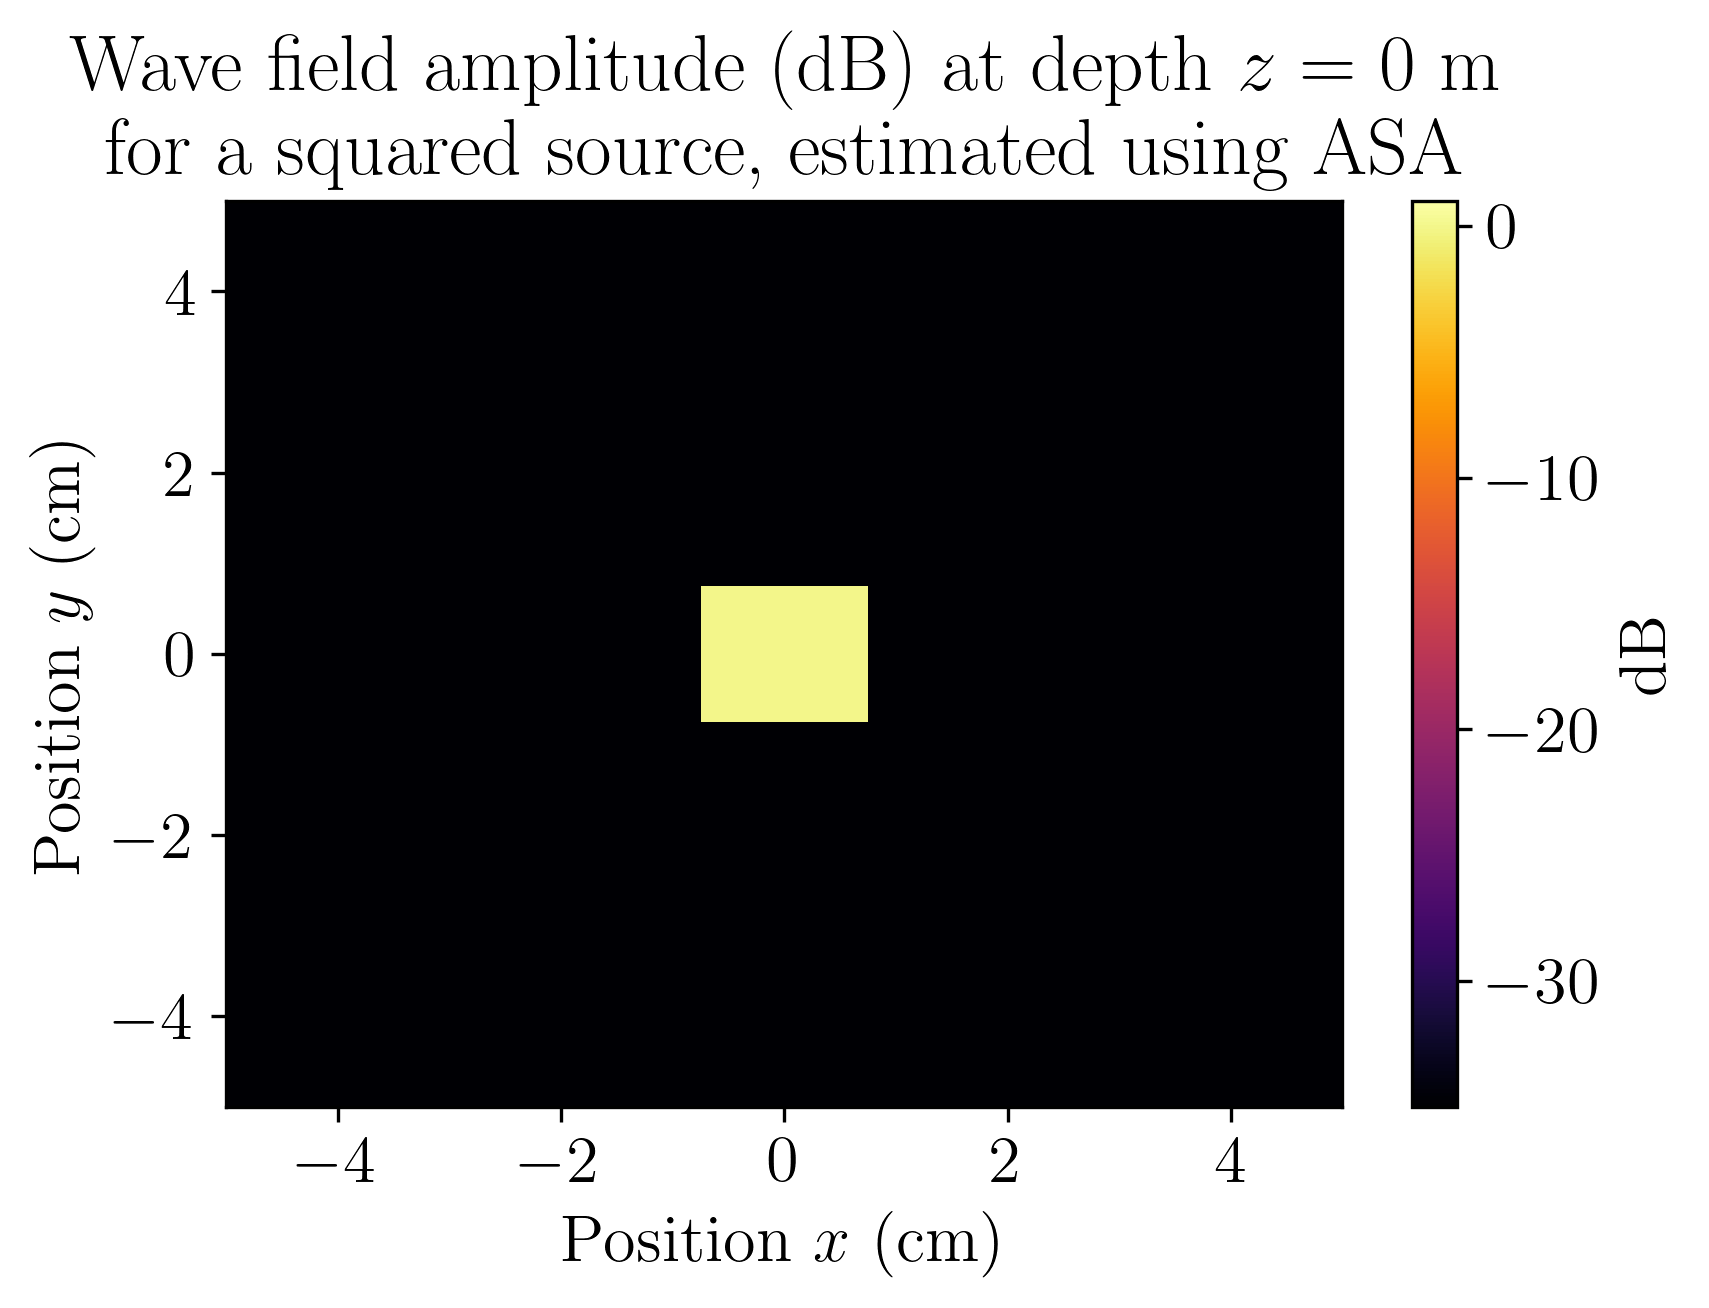

In [153]:
# Plot of the wave field in the aperture
abs_U_0_log = 10*np.log10(np.abs(U_0))
abs_U_0_log [ abs_U_0_log == -np.infty] = -60

plt.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*abs_U_0_log,cmap='inferno',shading='auto')
plt.clim(-35,1)
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Position $y$ (cm)')
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.title('Wave field amplitude (dB) at depth $z=0$ m \n for a squared source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')
plt.savefig('images/ASA/squared/wave_field_2D_z=0_squared.png',dpi=300)

U_0 = ASA_sources(config=config,type='square',r=radius)

Then, we can propagate this wave field to a depth $z$. The following plot represents the wave field at depth $z$ in the plane $xy$

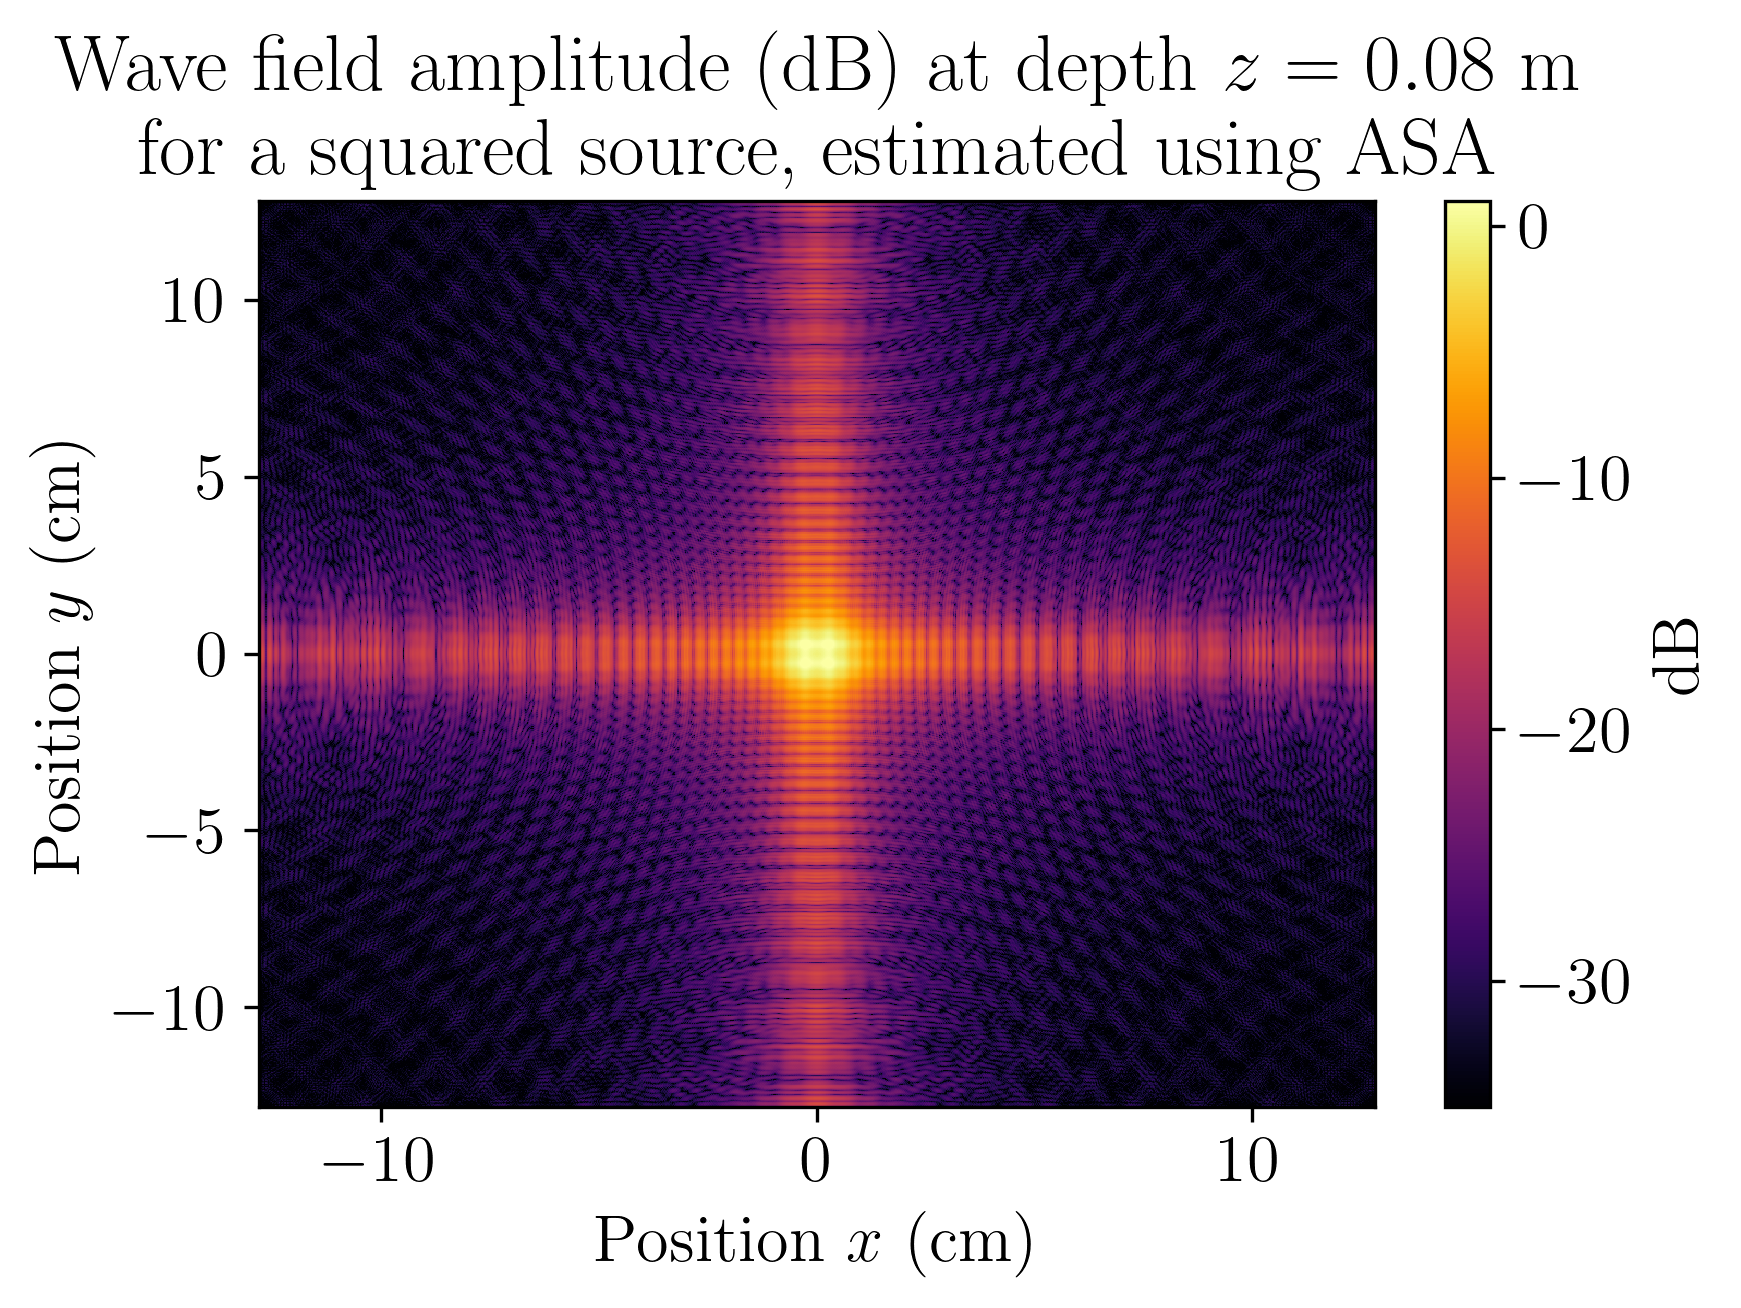

In [154]:
plt.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*np.log10(np.abs(U)),cmap='inferno',shading='auto')
plt.clim(-35,1)
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Position $y$ (cm)')
plt.title('Wave field amplitude (dB) at depth $z=0.08$ m \n for a squared source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')
plt.savefig('images/ASA/squared/wave_field_2D_z=8cm_squared.png',dpi=300)

We can also make a 3d plot of the wave field distribution at the depth $z$.

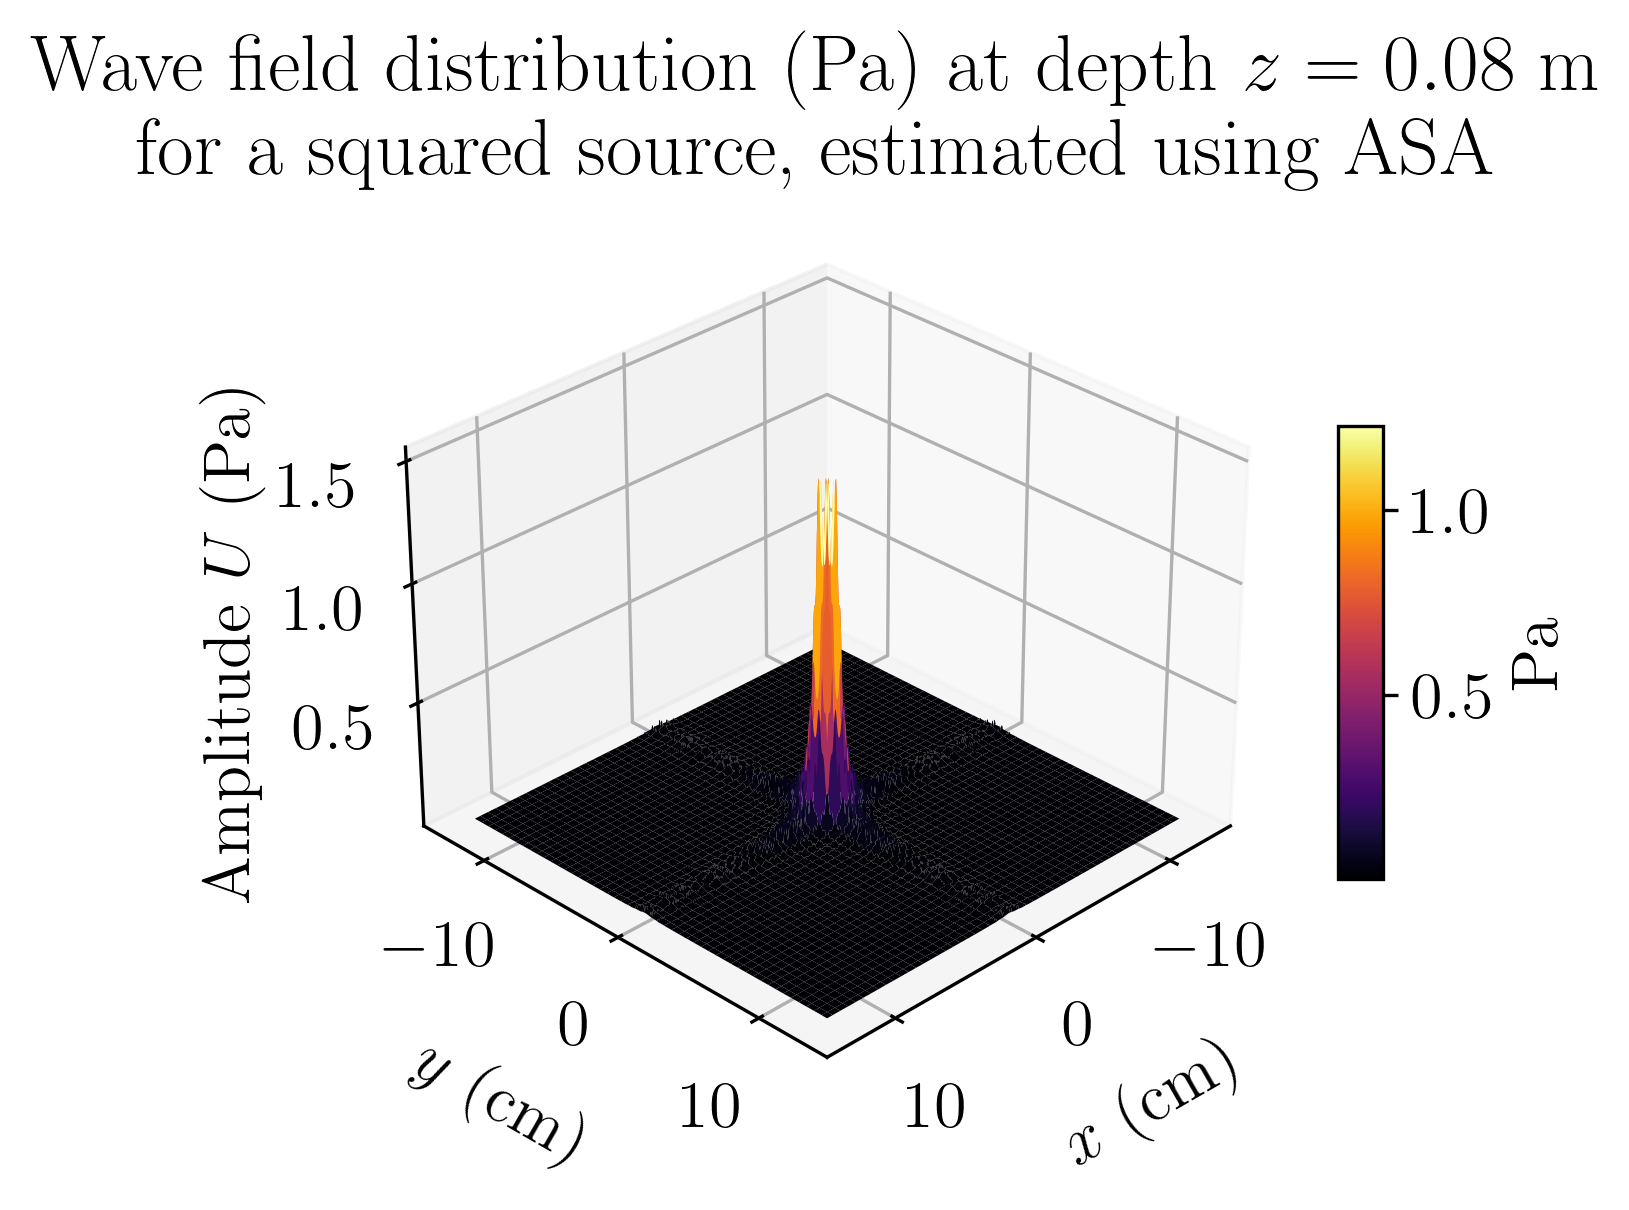

In [155]:
# 3d wave field distribution at the depth z
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X,Y = np.meshgrid(config['ax']*1e2,config['ay']*1e2)
surf = ax.plot_surface(X,Y,np.abs(U), cmap=cm.inferno,linewidth=0, antialiased=True)
ax.view_init(30, 45)
ax.set_xlabel('$x$ (cm)',labelpad=10)
ax.set_ylabel('$y$ (cm)',labelpad=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Amplitude $U$ (Pa)',rotation=90)
c = fig.colorbar(surf, shrink=0.5, aspect=10)
c.set_label('Pa')
ax.set_title('Wave field distribution (Pa) at depth $z=0.08$ m \n for a squared source, estimated using ASA')
plt.savefig('images/ASA/squared/wave_field_3D_z=8cm_squared.png',dpi=300)
plt.show()

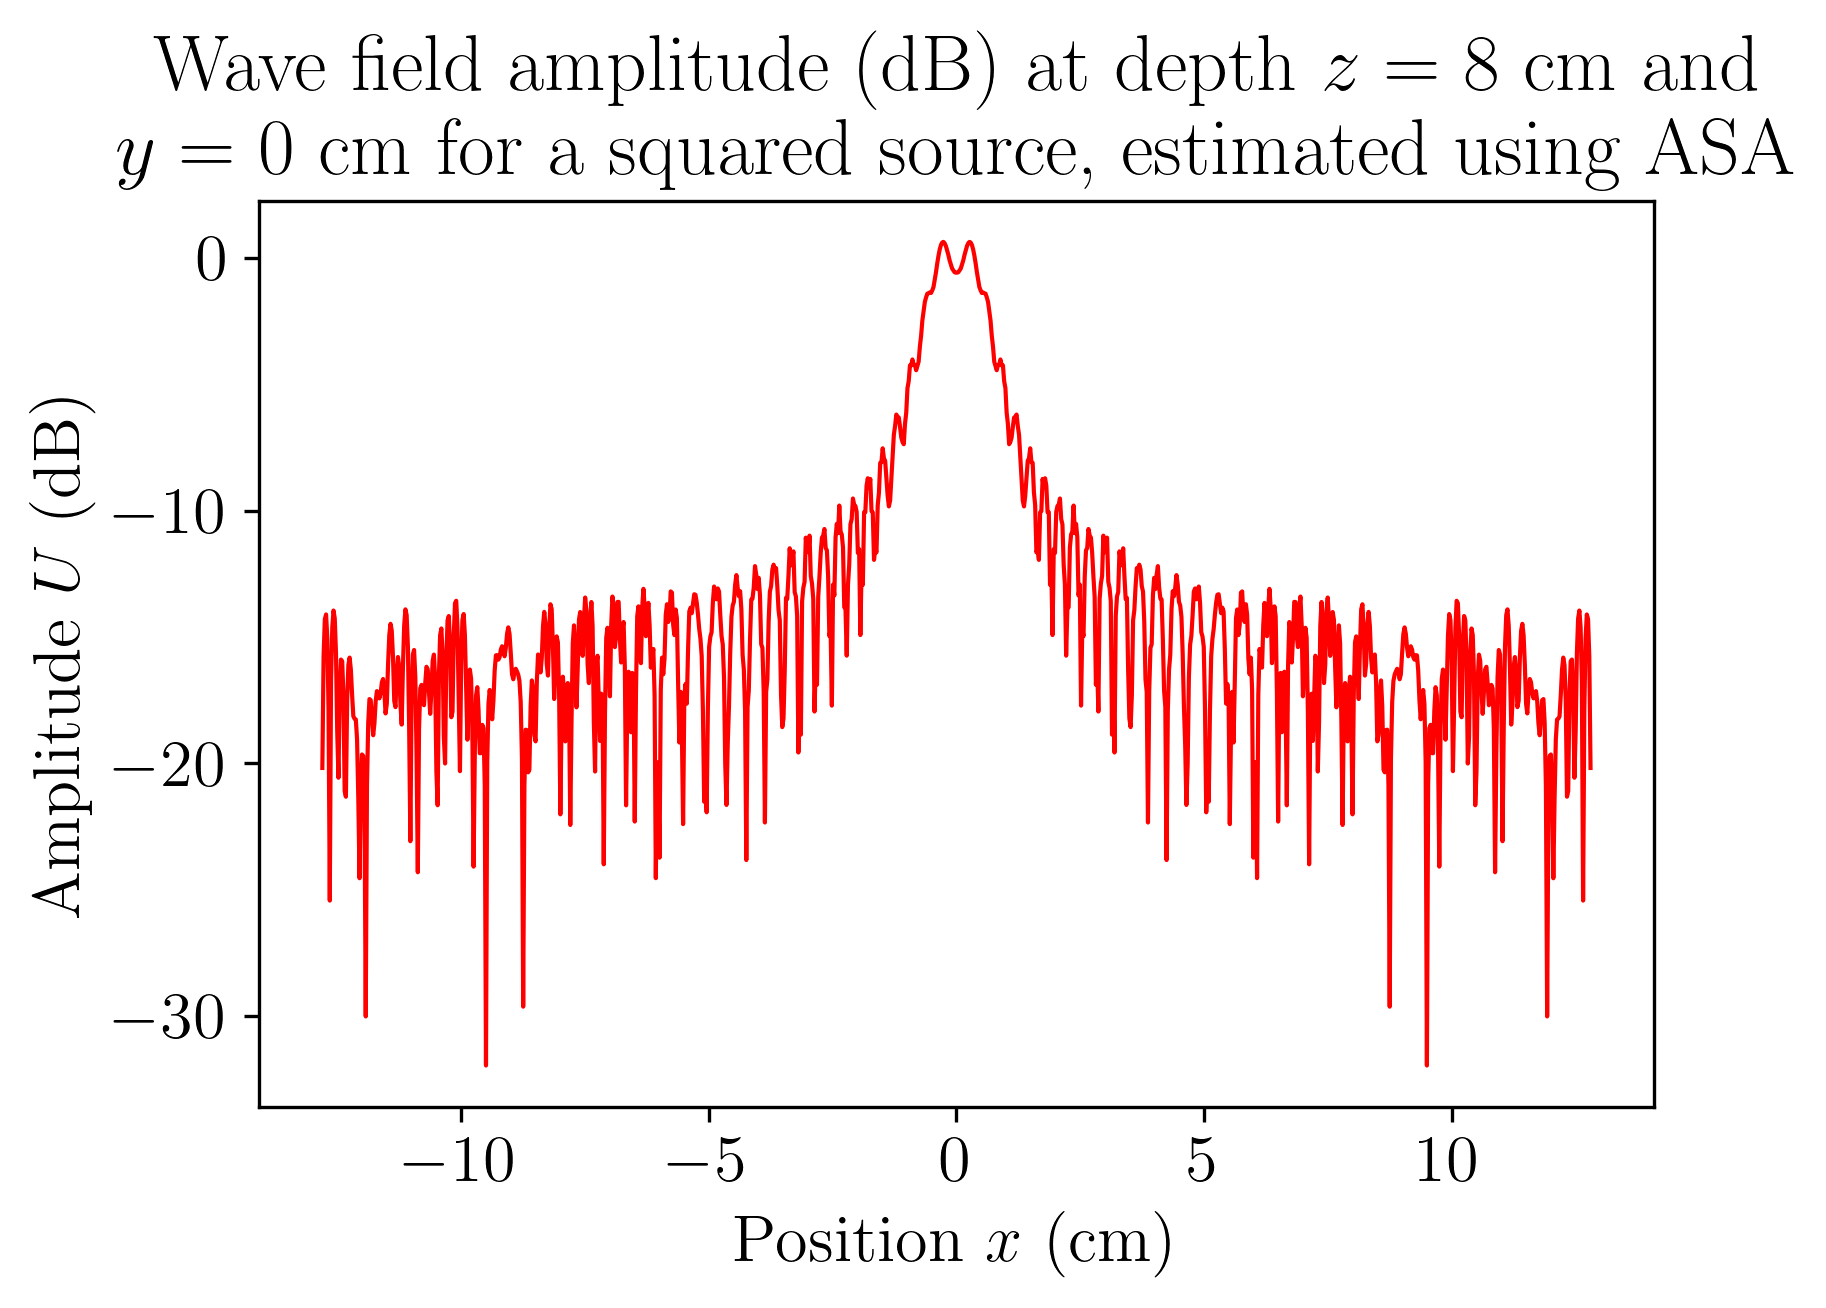

In [254]:
plt.plot(config['ax']*1e2,10*np.log10(np.abs(U[:,511])),color='red',linewidth=1)
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Amplitude $U$ (dB)')
plt.title('Wave field amplitude (dB) at depth $z=8$ cm and \n $y=0$ cm for a squared source, estimated using ASA')
plt.savefig('images/ASA/squared/wave_field_1D_z=8cm_squared.png')

The pressure distribution used in 1. has the shape of an ideal 2D lowpass filter. This causes a Gibbs effect in the spectrum. To reduce this effect, we can smooth the edges of the pressure distribution. The following MATLAB statements do this:

   > Kernel = hanning(3)*hanning(3).’;
   
   > Kernel = Kernel/sum(Kernel(:));
   
   > U0Mod = conv2(U0,Kernel,’same’);
   
One way to see the effect of this smoothing is to compare the spectrum from an aperture with and without smoothed edges at a short range, for instant at $z = \lambda$.

## Q.2. Continuous aperture

For the same setup as above, modify the ASA-script to predict the field in steps of a few $\lambda$ to a chosen range $z$, using the smoothed pressure distribution $\texttt{U_0_Mod}$ instead of $\texttt{U0}$.            

In [108]:
# We define the hanning window (as defined in MATLAB)

hanning_window = np.array([[0.25,0.5,0.25],[0.5,1,0.5],[0.25,0.5,0.25]])
hanning_window = hanning_window/np.sum(hanning_window)

print(hanning_window)

[[0.0625 0.125  0.0625]
 [0.125  0.25   0.125 ]
 [0.0625 0.125  0.0625]]


In [109]:
# We apply the filter to our source : we convolve the filter and the wave field in the aperture

U_0_mod = scipy.signal.convolve2d(U_0,hanning_window,'same')

### 2.1 Make a 2D image of the predicted wave field for y = 0.

Here, we simulate the wave field along the $x$-axis (for $y=0$) for multiple depths $z$. 

In [110]:
# This cell may take few moments to be processed !

# Minimum and maximum z values
z_min = 0 #m
z_max = 2 #m
# Number of points for the z-axis
Nz=2000
# Sampling period 
depth_sampling_period = (z_max-z_min)/Nz

# Depth vector Z
Z = np.arange(z_min,z_max,depth_sampling_period)

# Wave field matrix W (each column <-> wavefield for all x, at y=0 cm and z)

W = np.zeros((config['Nx'],len(Z)),dtype='complex')

for i in tqdm(range(len(Z))) :
    
    # We compute the propagation matrix
    prop = ASA_propagator(config=config,z=Z[i])
    # We propagate the wave field
    U_ = custom_ifft2(custom_fft2(U_0_mod)*prop)
    W[:,i] = U_[:,config['Ny']//2]
    



  0%|                                                  | 0/2000 [00:00<?, ?it/s]/Users/thomasaussagues/SynologyDrive/Drive/UiO/Signal Array Processing/Exercices/Mandatory1/Jupyter/utils/ASA.py:47: RuntimeWarning: invalid value encountered in sqrt
  prop = np.exp(1j * 2 * np.pi * z * np.sqrt(1 - uSq - vSq) / config['lambda'] )
100%|███████████████████████████████████████| 2000/2000 [02:55<00:00, 11.42it/s]


Then, we plot the computed wave field along the $x$-axis for all $z$.

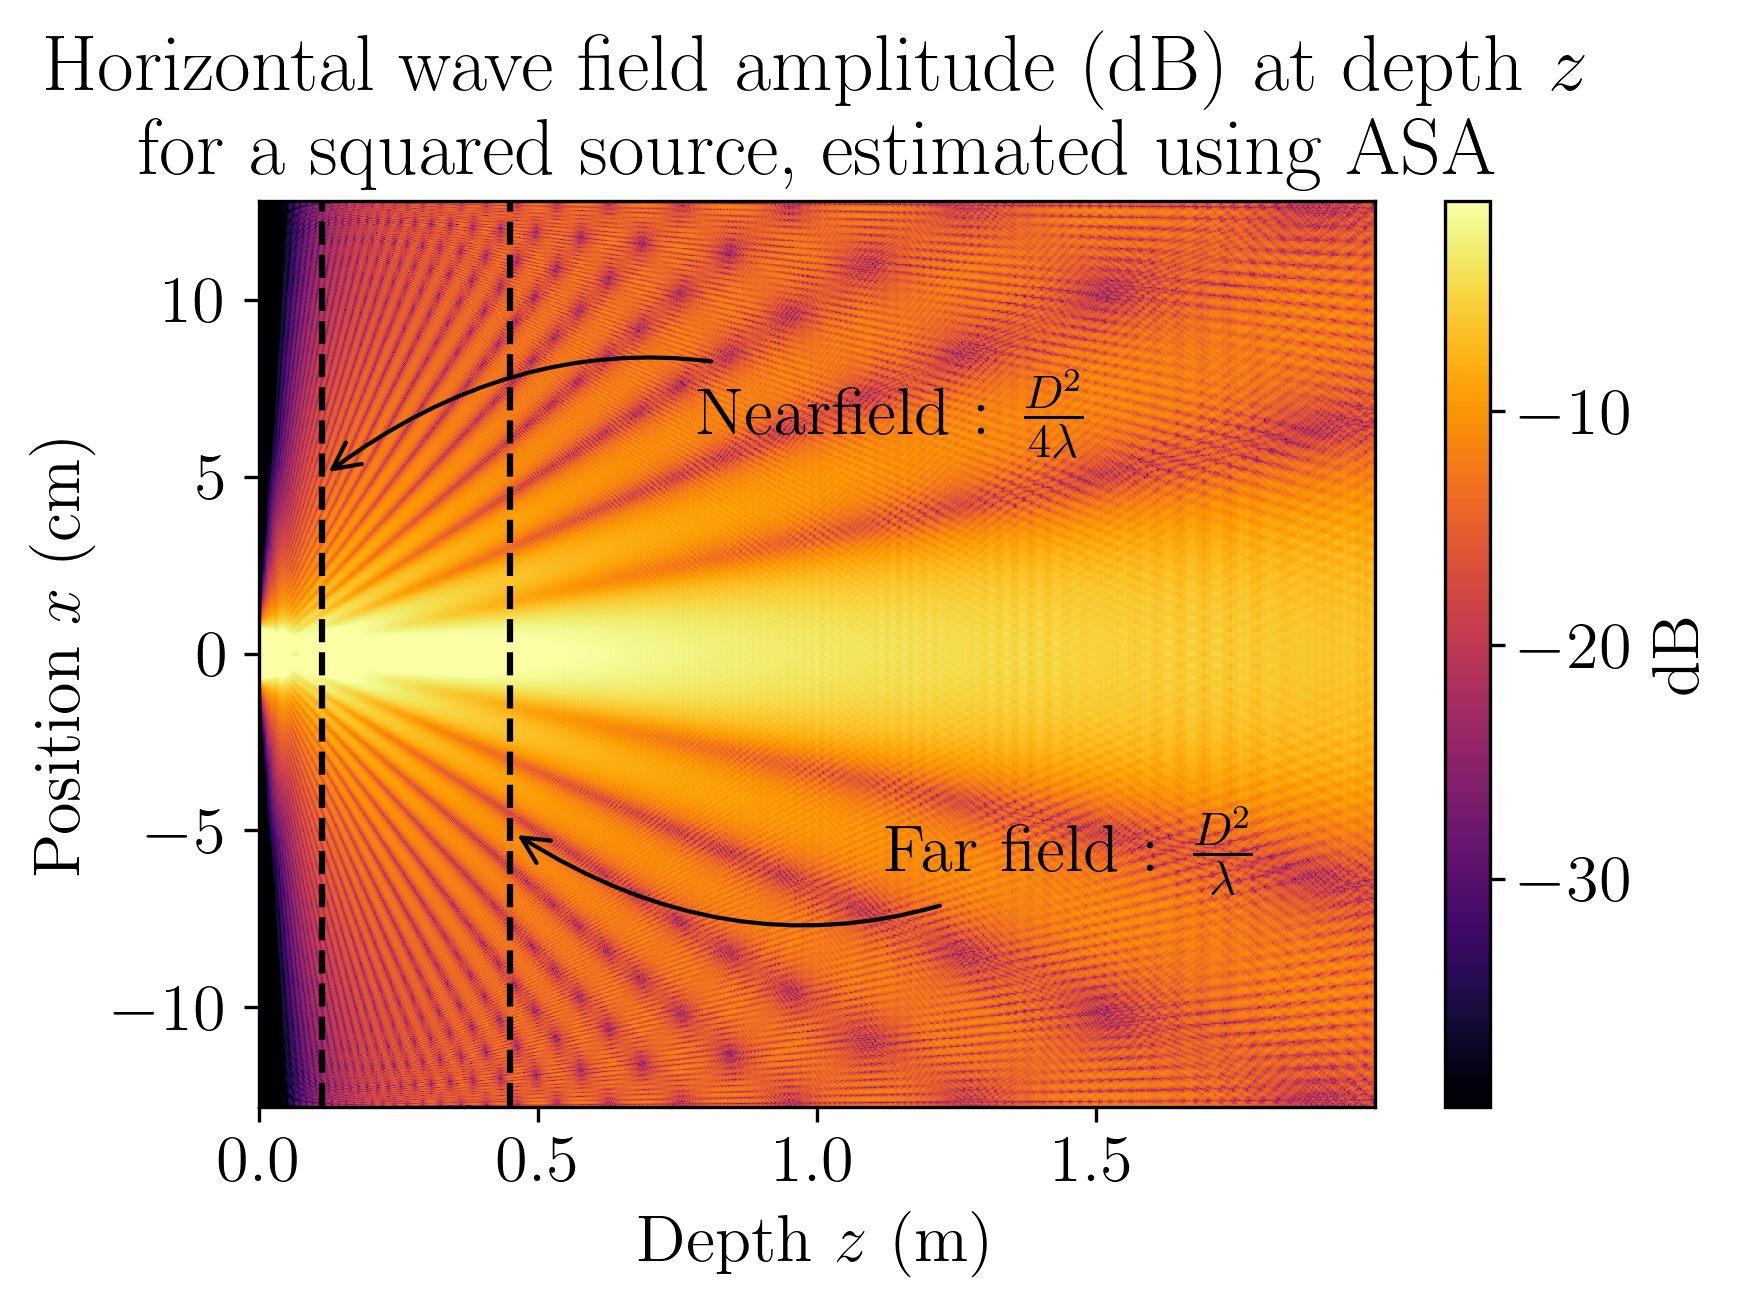

In [141]:
# 2D image of the predicted wavefield for y=0m

plt.pcolormesh(Z,config['ax']*1e2,10*np.log10(np.abs(W)),cmap='inferno',shading='auto')
plt.clim(np.min(10*np.log10(np.abs(W[-1,:])))+40,np.max(np.log10(np.abs(W[-1,:]))))

near_field_limit = (2*radius)**2/(4*config['lambda'])
far_field_limit = (2*radius)**2/config['lambda']

plt.plot([near_field_limit,near_field_limit],[np.min(config['ax'])*1e2,np.max(config['ax'])*1e2],linestyle='--',color='k')
plt.plot([far_field_limit,far_field_limit],[np.min(config['ax'])*1e2,np.max(config['ax'])*1e2],linestyle='--',color='k')
plt.ylabel('Position $x$ (cm)')
plt.xlabel('Depth $z$ (m)')
plt.title('Horizontal wave field amplitude (dB) at depth $z$\n for a squared source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')

plt.annotate('Nearfield : $\\frac{D^2}{4\\lambda}$',
         xy=(near_field_limit, 0.05*1e2), xycoords='data',
         xytext=(+90, +10), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=+.3"))

plt.annotate('Far field : $\\frac{D^2}{\\lambda}$',
         xy=(far_field_limit, -0.05*1e2), xycoords='data',
         xytext=(+90, -10), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))

plt.savefig('images/ASA/squared/wave_field_2D_xz_square_smoothed.png',dpi=300)

### 2.2 Plot the pressure for the center of the field for all ranges (i.e. a 1S plot, along the z-axis, and starting in origo).

Here, we plot the pressure at the field center for all depths $z$.

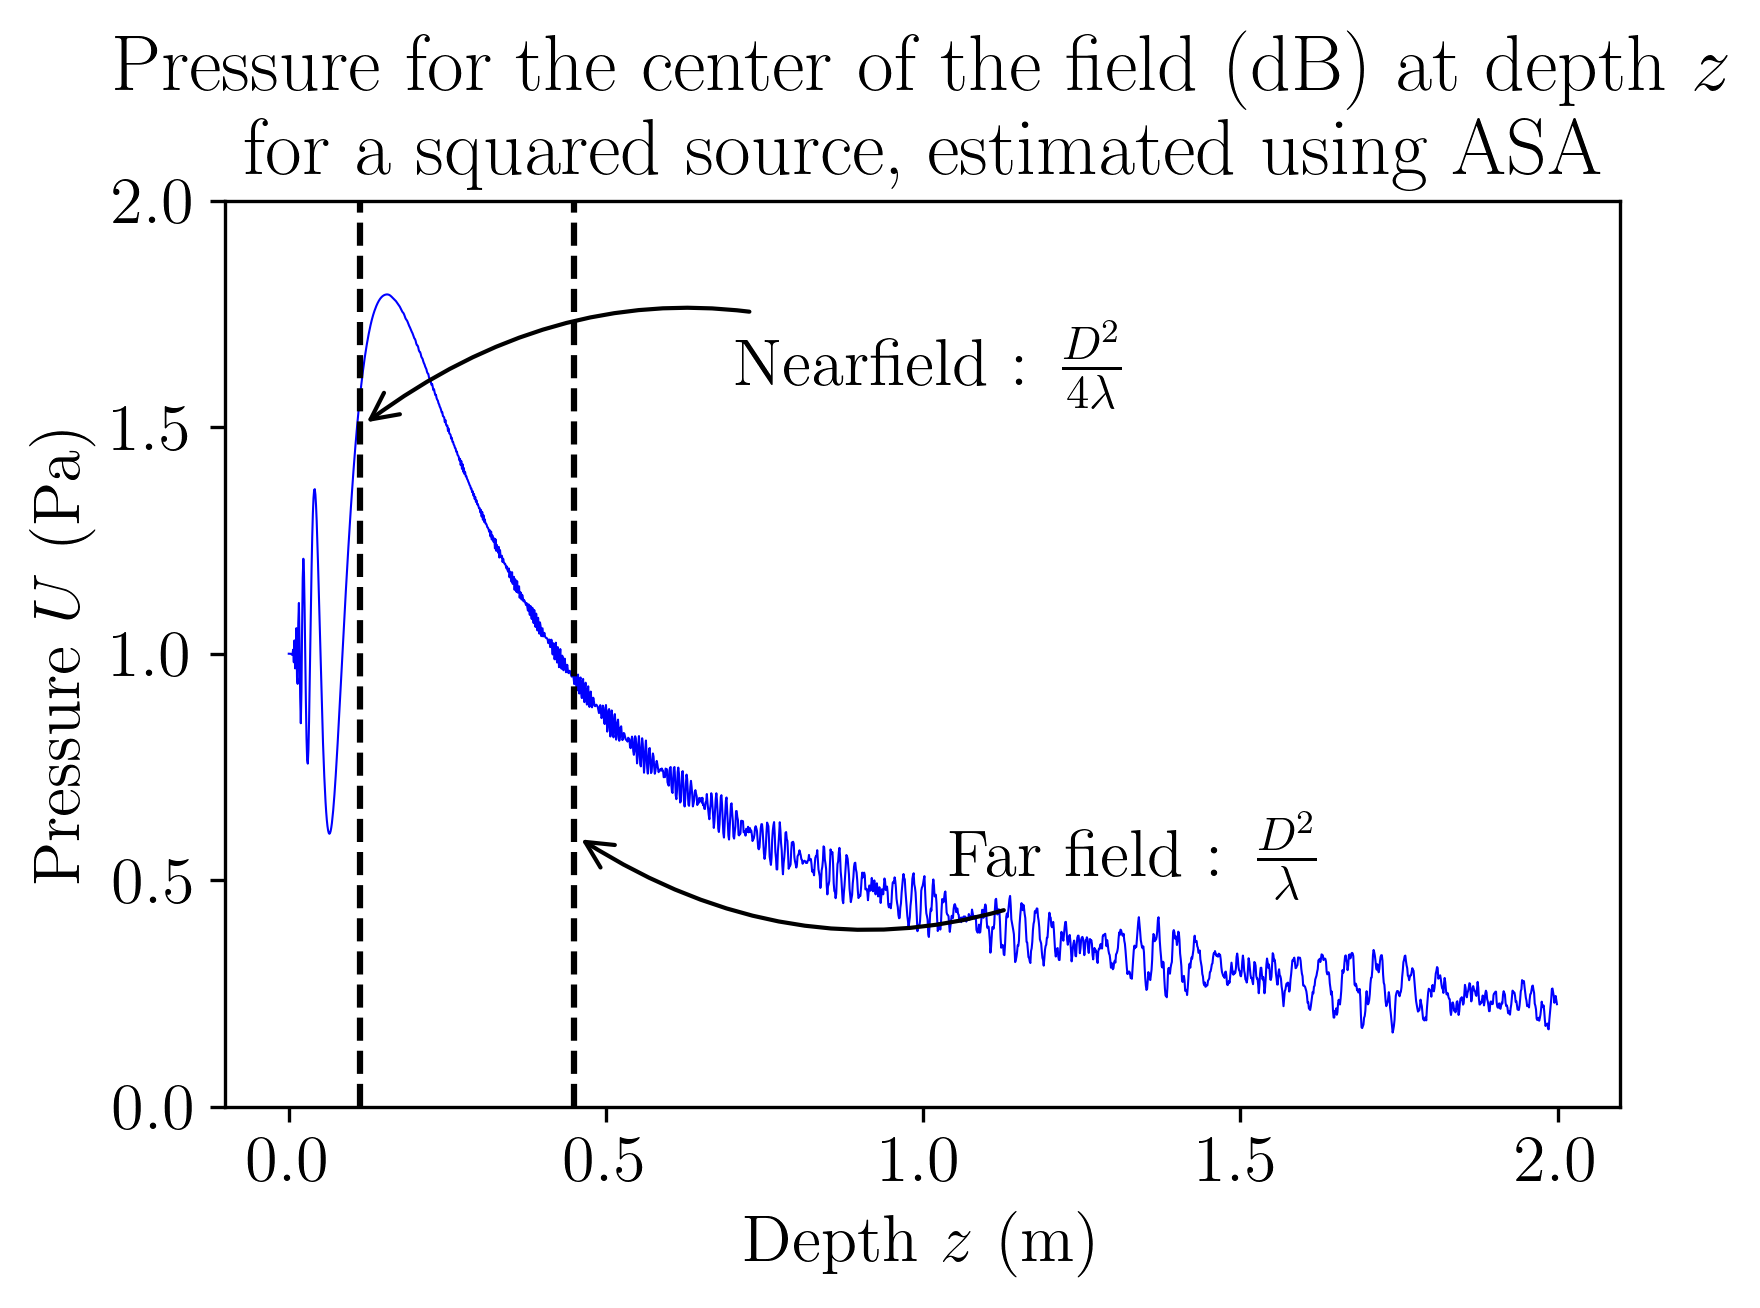

In [142]:
# Plot the pressure for the center of the field for all ranges (i.e. a 1S plot, along the z-axis,
# and starting in origo).

plt.plot(Z,np.abs(W[config['Nx']//2,:]),color='blue',linewidth=0.5)
plt.xlabel('Depth $z$ (m)')
plt.ylabel('Pressure $U$ (Pa)')
plt.title('Pressure for the center of the field (dB) at depth $z$ \n for a squared source, estimated using ASA')

plt.plot([near_field_limit,near_field_limit],[0,2],linestyle='--',color='k')
plt.plot([far_field_limit,far_field_limit],[0,2],linestyle='--',color='k')

plt.annotate('Nearfield : $\\frac{D^2}{4\\lambda}$',
         xy=(near_field_limit, 1.5), xycoords='data',
         xytext=(+90, +10), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=+.3"))

plt.annotate('Far field : $\\frac{D^2}{\\lambda}$',
         xy=(far_field_limit, 0.6), xycoords='data',
         xytext=(+90, -10), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))

plt.ylim([0,2])

plt.savefig('images/ASA/squared/wave_field_1D_center_square_smoothed.png',dpi=300)

### 2.3 Plot the center cut of the wave field (as in 1.) at the near-field farfield limit. Describe how you defined this limit.


Limit definition ?????????

/Users/thomasaussagues/SynologyDrive/Drive/UiO/Signal Array Processing/Exercices/Mandatory1/Jupyter/utils/ASA.py:47: RuntimeWarning: invalid value encountered in sqrt
  prop = np.exp(1j * 2 * np.pi * z * np.sqrt(1 - uSq - vSq) / config['lambda'] )


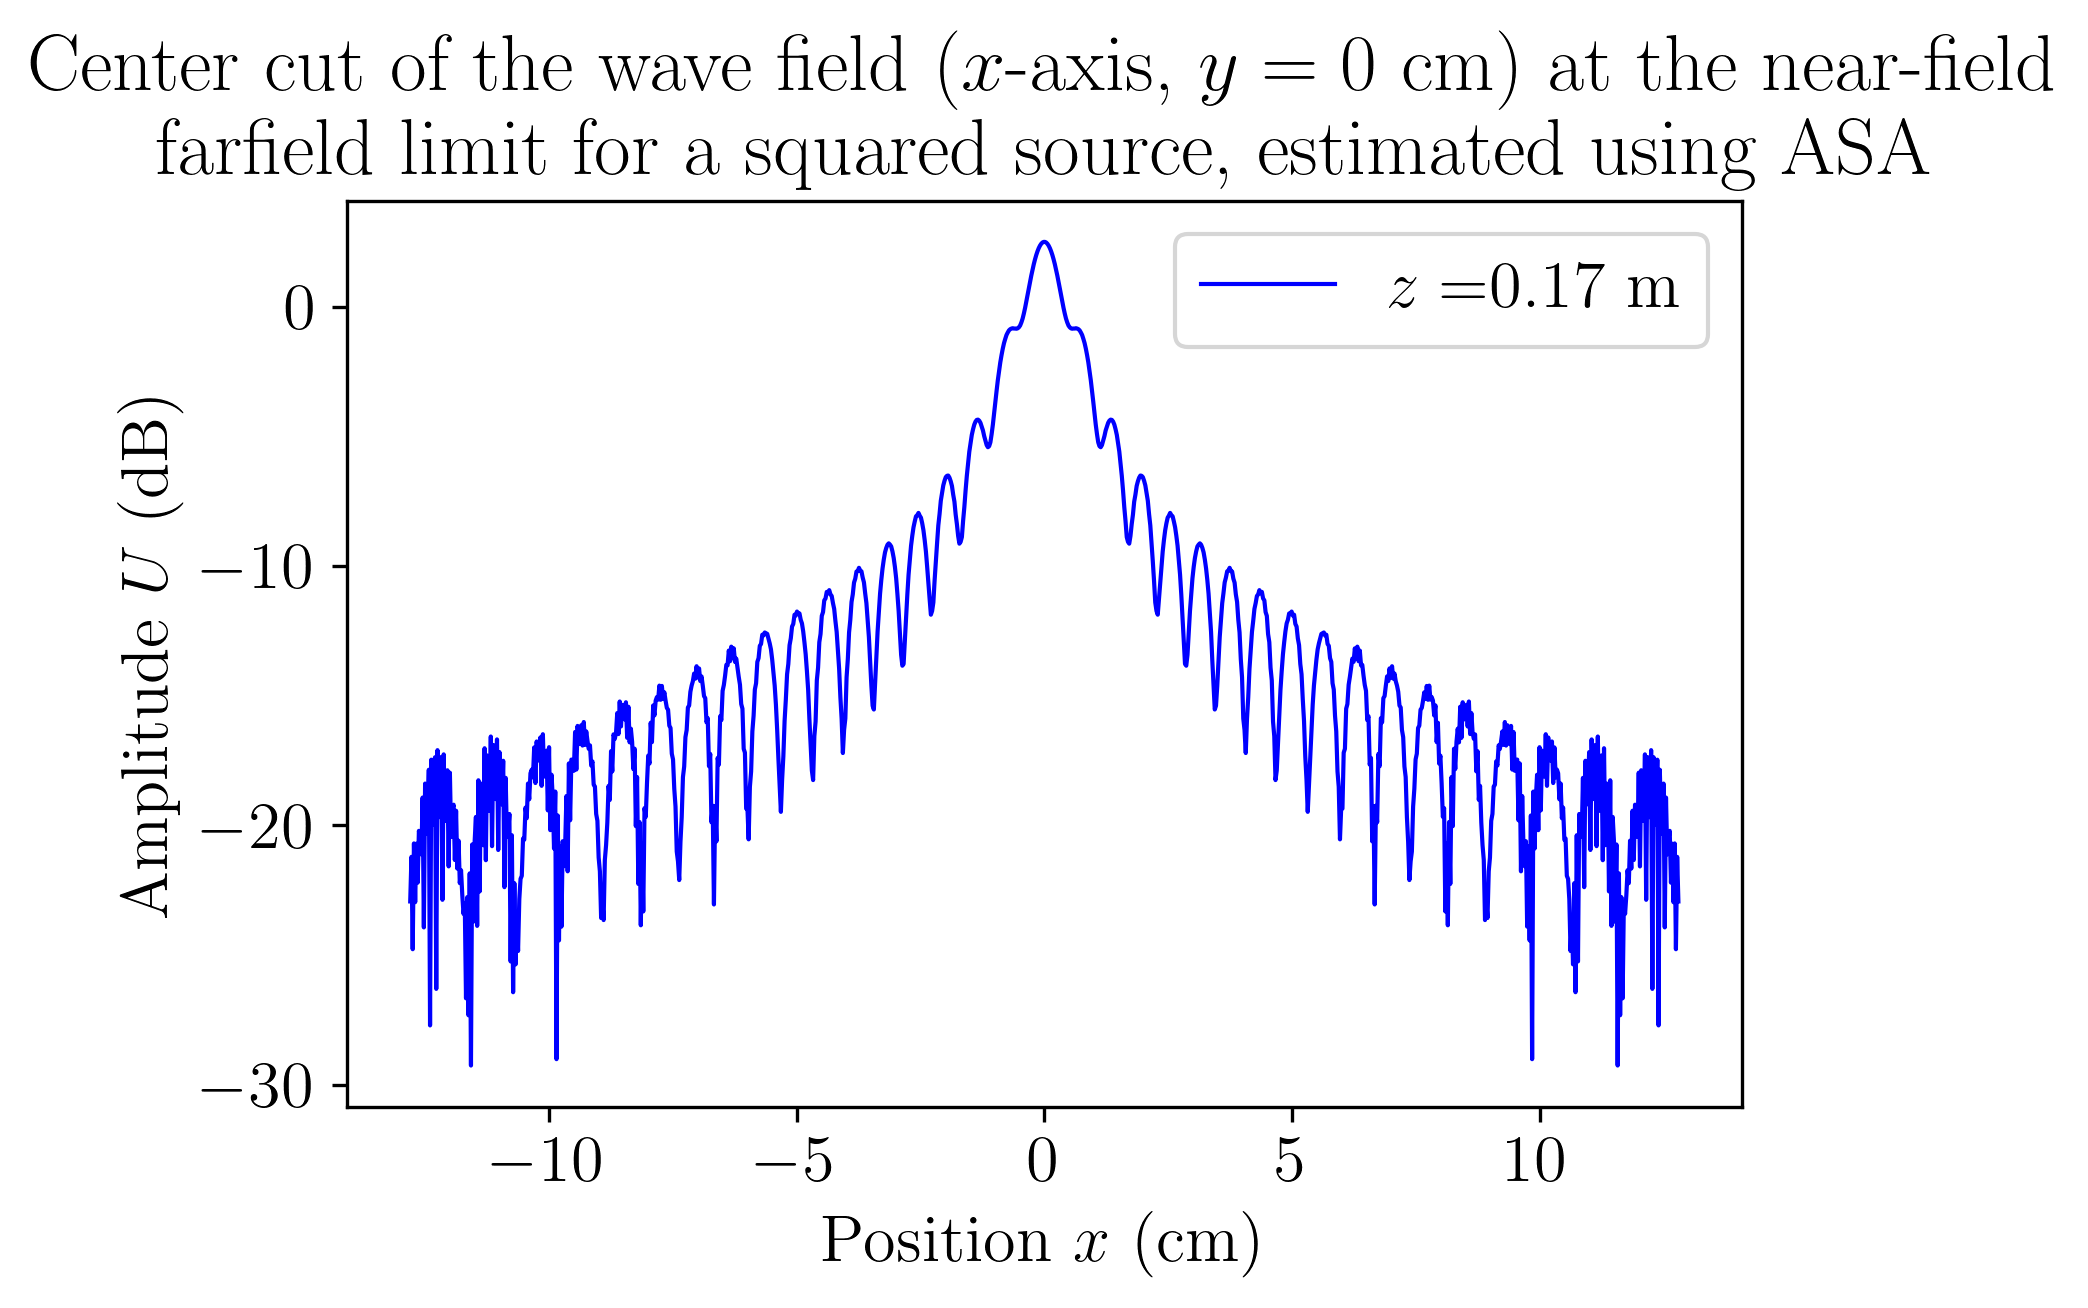

In [143]:
# Plot the center cut of the wave field (as in 1.) at the near-field farfield limit. 

z_middle = (far_field_limit-near_field_limit)/2
prop = ASA_propagator(config=config,z=z_middle)
U_mod = custom_ifft2(custom_fft2(U_0_mod)*prop)

plt.plot(config['ax']*1e2,10*np.log10(np.abs(U_mod[:,config['Nx']//2])),color='blue',linewidth=1,label = '$z=${:.2f} m'.format(z_middle))
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Amplitude $U$ (dB)')
plt.legend(loc='best')
plt.title('Center cut of the wave field ($x$-axis, $y=0$ cm) at the near-field\nfarfield limit for a squared source, estimated using ASA')

plt.savefig('images/ASA/squared/wave_field_1D_near_far_limit_squared_smoothed.png',dpi=300)

### 2.4 Plot the center cut of the wave field at a range much larger than the near-field farfield limit.

/Users/thomasaussagues/SynologyDrive/Drive/UiO/Signal Array Processing/Exercices/Mandatory1/Jupyter/utils/ASA.py:47: RuntimeWarning: invalid value encountered in sqrt
  prop = np.exp(1j * 2 * np.pi * z * np.sqrt(1 - uSq - vSq) / config['lambda'] )


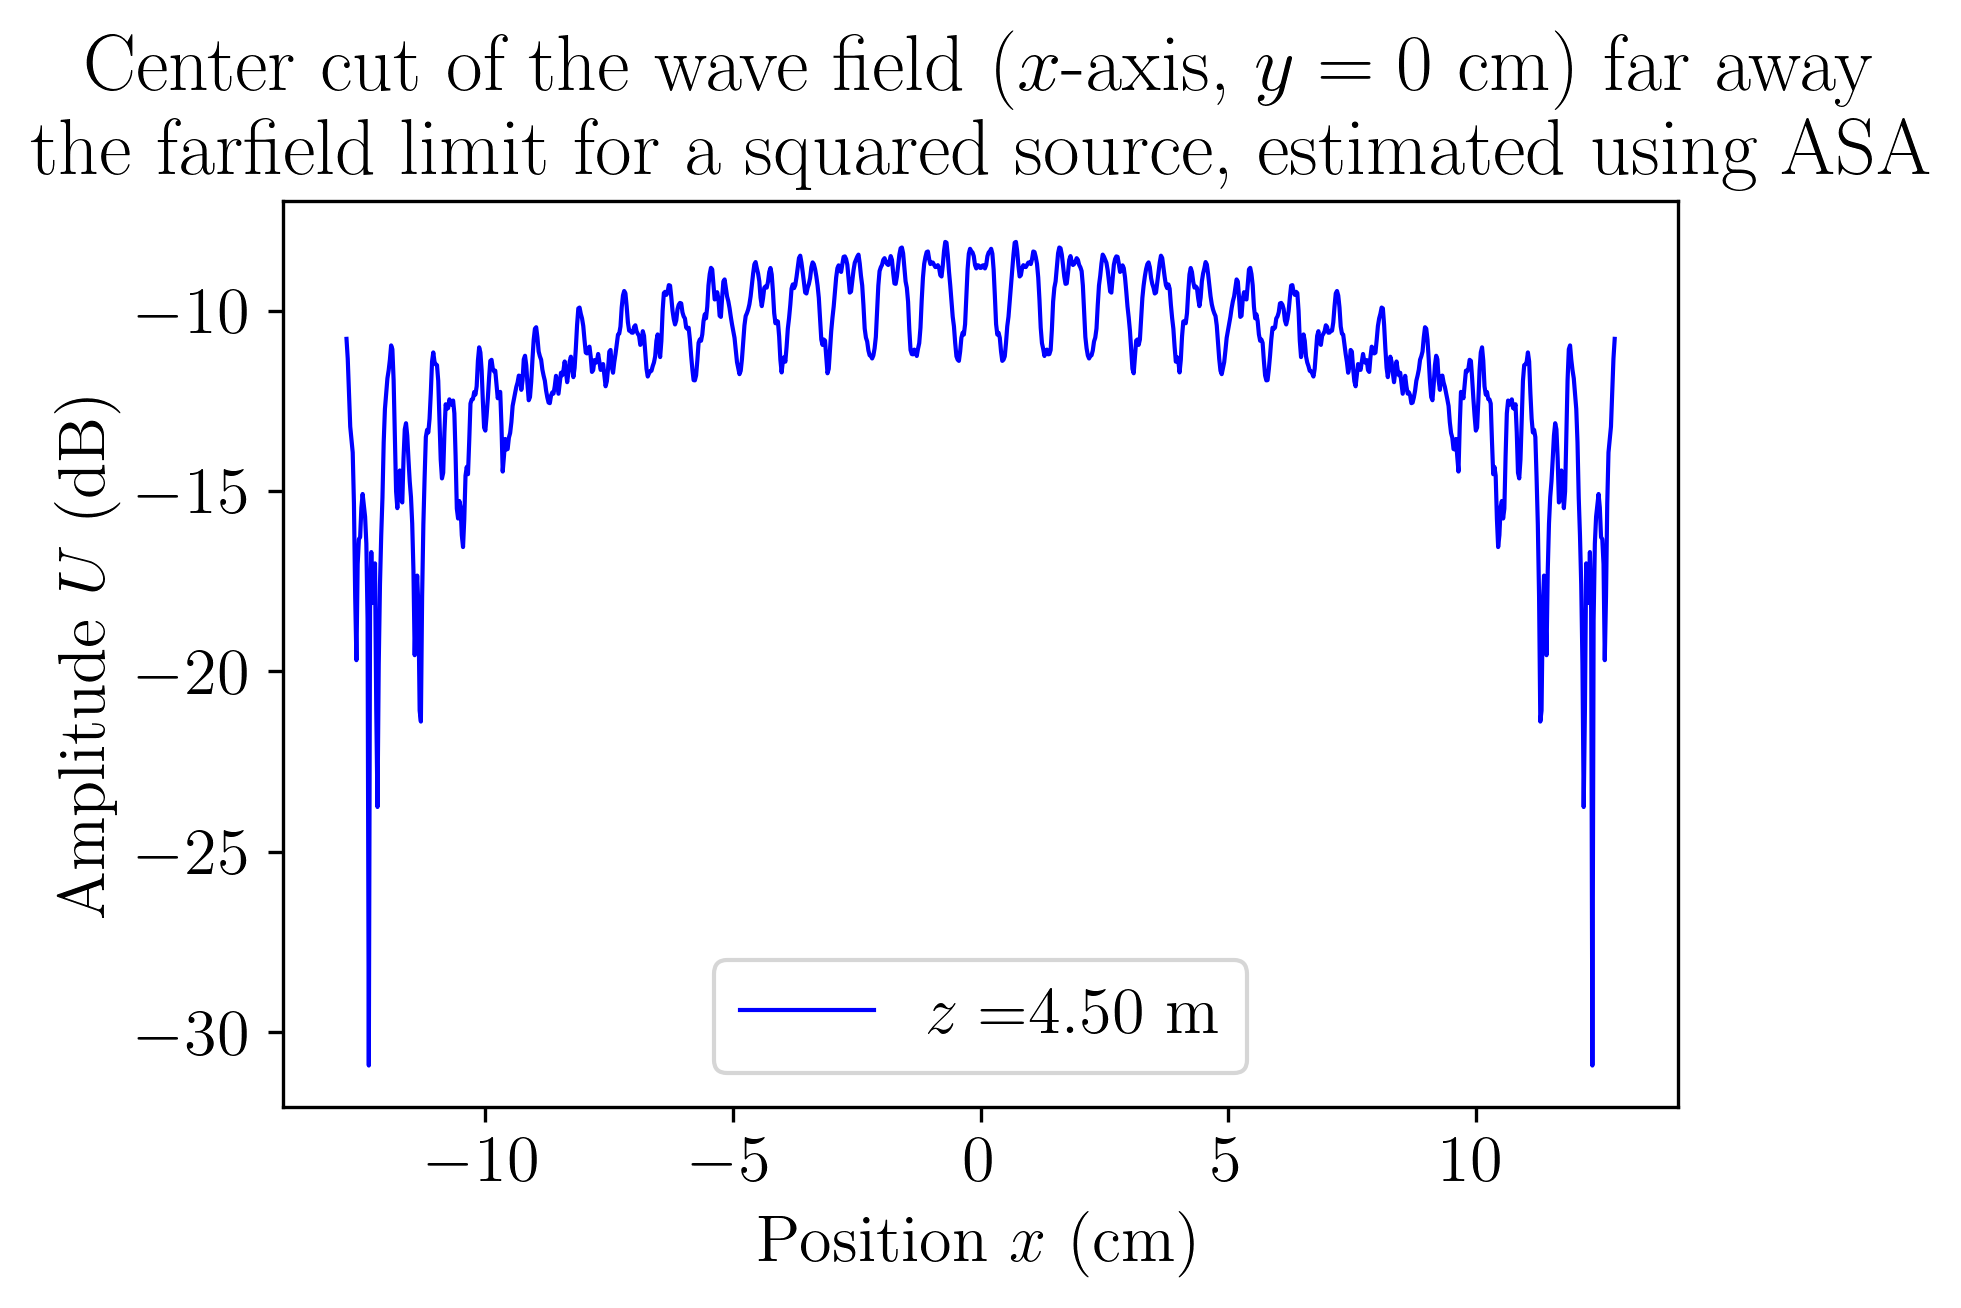

In [144]:
# Plot the center cut of the wave field at a range much larger than the near-field farfield limit.

z_far = far_field_limit*10
prop = ASA_propagator(config=config,z=z_far)
U_mod = custom_ifft2(custom_fft2(U_0_mod)*prop)

plt.plot(config['ax']*1e2,10*np.log10(np.abs(U_mod[:,config['Nx']//2])),color='blue',linewidth=1,label = '$z=${:.2f} m'.format(z_far))
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Amplitude $U$ (dB)')
plt.title('Center cut of the wave field ($x$-axis, $y=0$ cm) far away\n  the farfield limit for a squared source, estimated using ASA')
plt.legend(loc='best')
plt.savefig('images/ASA/squared/wave_field_1D_far_limit_squared_smoothed.png',dpi=300)

### 2.5 Without and with hanning window

Here, we plot the same figures as in 1. but with a smoothed aperture

In [145]:
config = get_params()
radius = 15*config['lambda']
prop = ASA_propagator(config=config,z=0.08)


U_mod = custom_ifft2(custom_fft2(U_0_mod)*prop)

/Users/thomasaussagues/SynologyDrive/Drive/UiO/Signal Array Processing/Exercices/Mandatory1/Jupyter/utils/ASA.py:47: RuntimeWarning: invalid value encountered in sqrt
  prop = np.exp(1j * 2 * np.pi * z * np.sqrt(1 - uSq - vSq) / config['lambda'] )


/var/folders/cw/5xff940s6559c90nyhzx9s9m0000gn/T/ipykernel_1063/784167779.py:2: RuntimeWarning: divide by zero encountered in log10
  abs_U_0_mod_log = 10*np.log10(np.abs(U_0_mod))


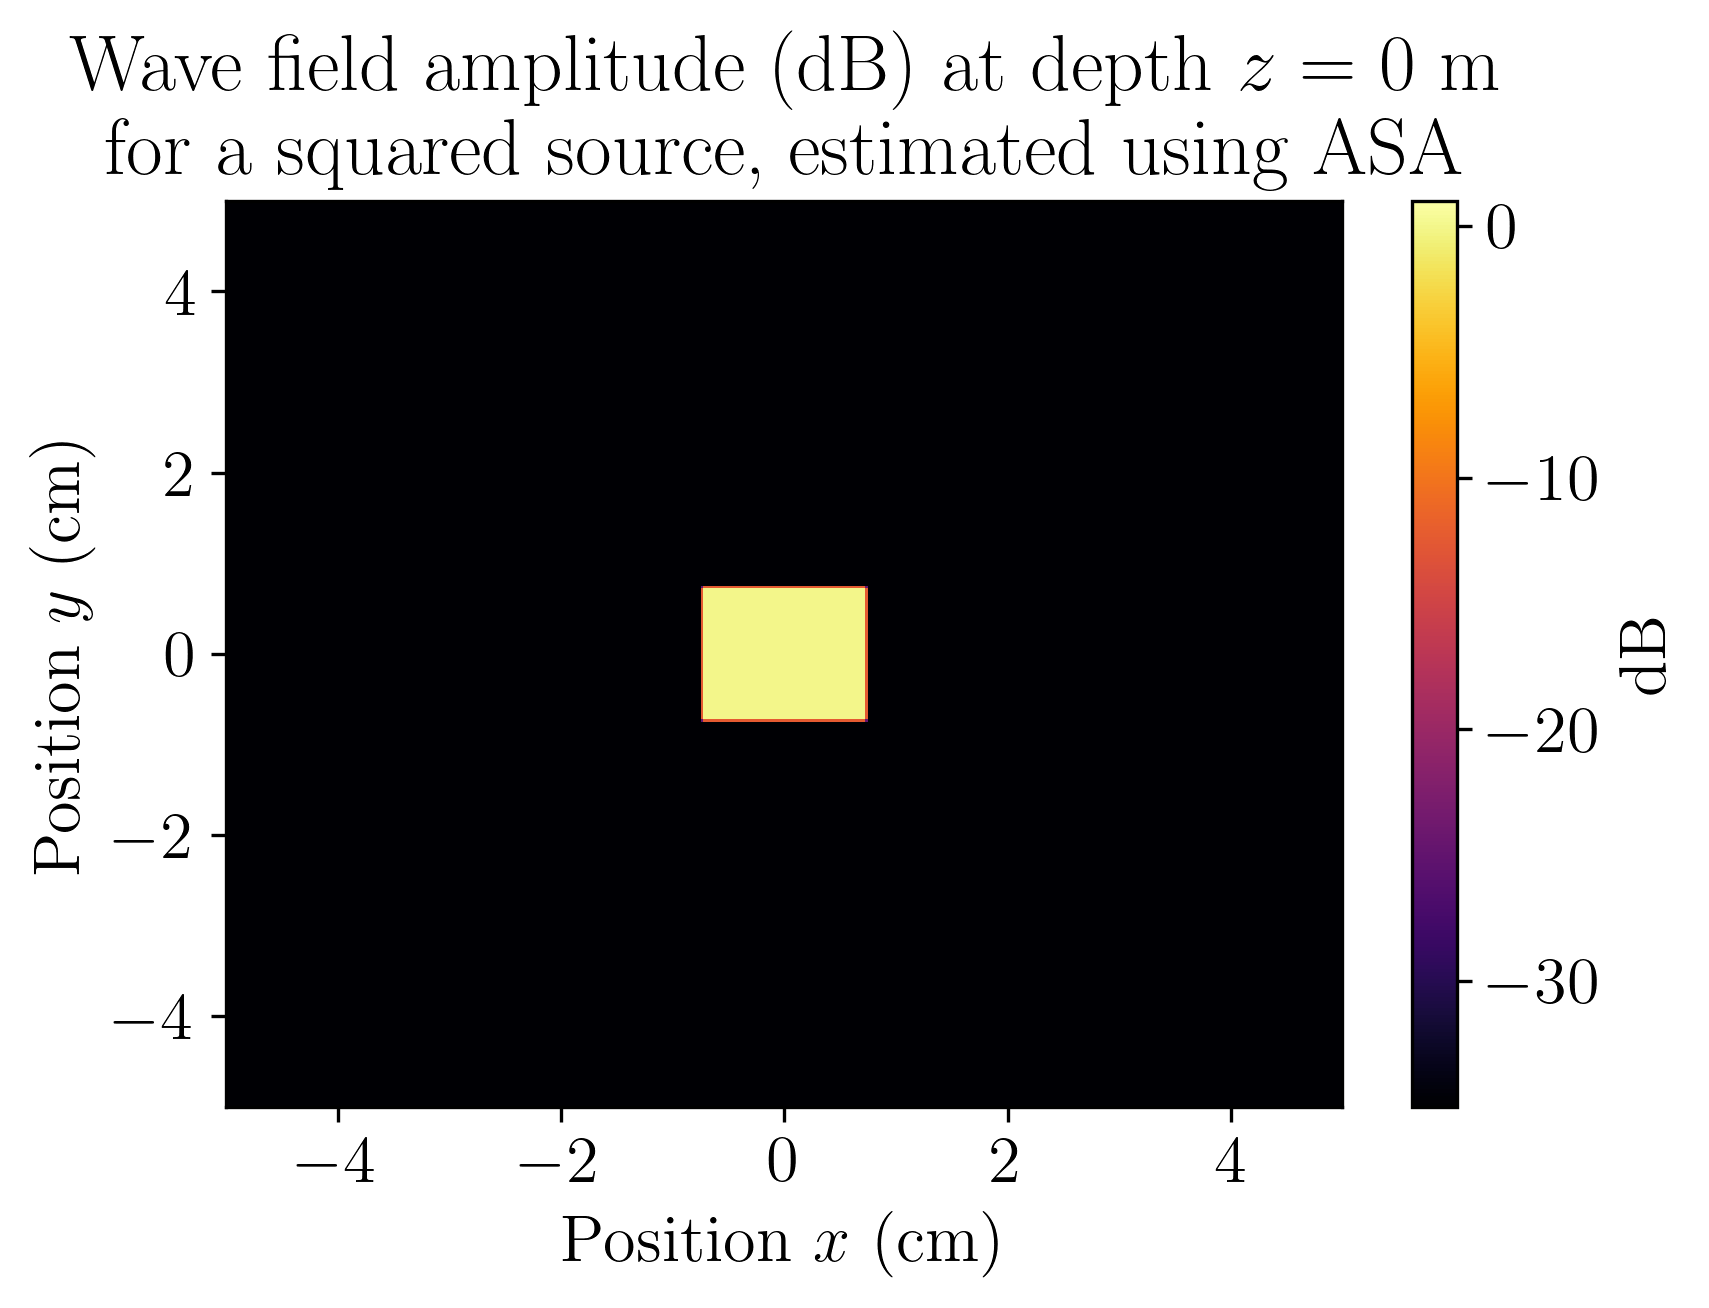

In [146]:
# Plot of the wave field in the aperture
abs_U_0_mod_log = 10*np.log10(np.abs(U_0_mod))
abs_U_0_mod_log [ abs_U_0_mod_log == -np.infty] = -60

plt.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*abs_U_0_mod_log,cmap='inferno',shading='auto')
plt.clim(-35,1)
plt.xlim([-5,5])
plt.ylim([-5,5])
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Position $y$ (cm)')
plt.title('Wave field amplitude (dB) at depth $z=0$ m \n for a squared source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')
plt.savefig('images/ASA/squared/wave_field_2D_z=0_squared_smoothed.png',dpi=300)

U_0 = ASA_sources(config=config,type='square',r=radius)

/var/folders/cw/5xff940s6559c90nyhzx9s9m0000gn/T/ipykernel_1063/1420618273.py:19: RuntimeWarning: divide by zero encountered in log10
  abs_U_0_log = 10*np.log10(np.abs(U_0))
/var/folders/cw/5xff940s6559c90nyhzx9s9m0000gn/T/ipykernel_1063/1420618273.py:29: RuntimeWarning: divide by zero encountered in log10
  abs_U_0_mod_log = 10*np.log10(np.abs(U_0_mod))


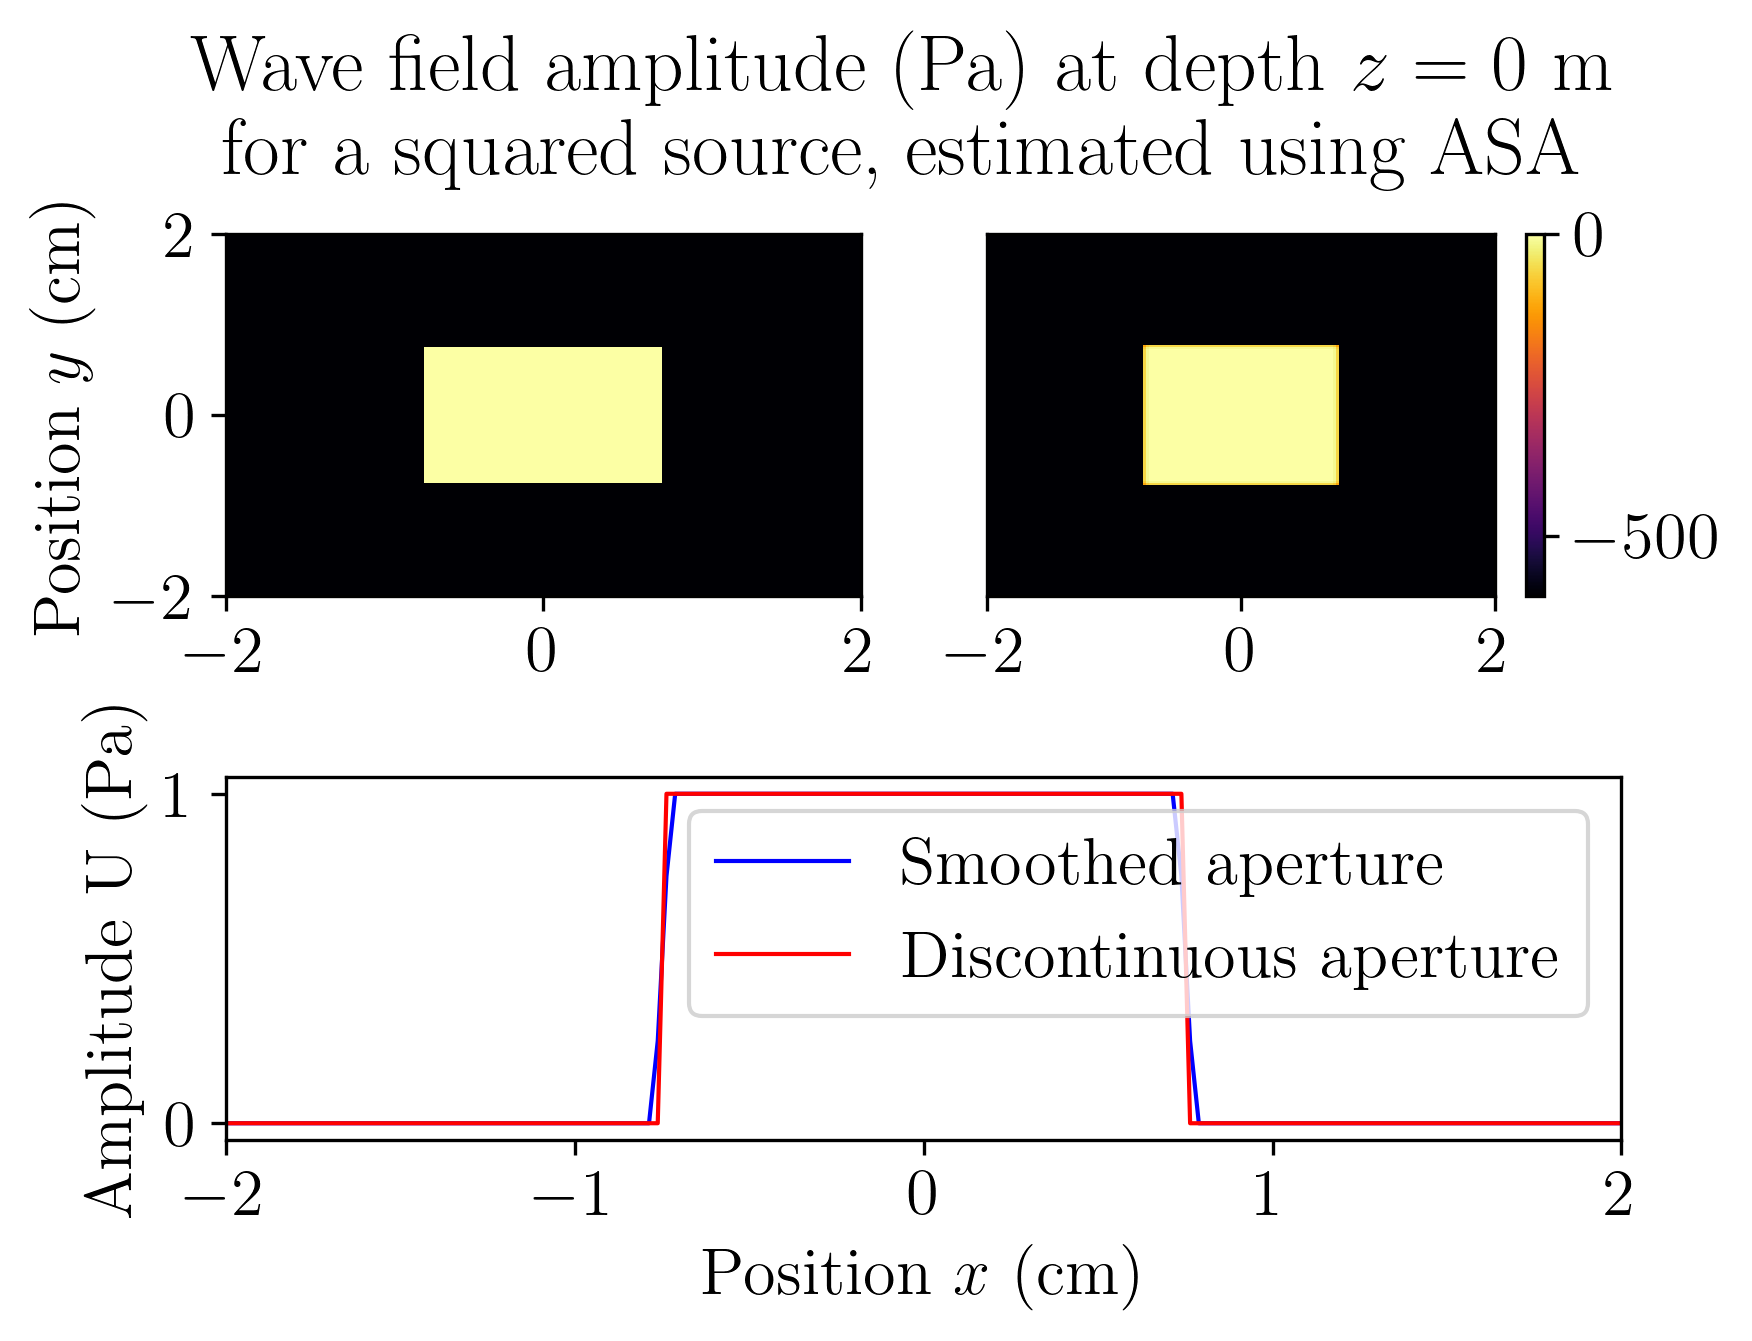

In [232]:


ax1 = plt.subplot(212)







ax1.plot(config['ax']*1e2,np.abs(U_0_mod[:,511]),color='blue',label = 'Smoothed aperture',linewidth=1)
ax1.plot(config['ax']*1e2,np.abs(U_0[:,511]),color='red',label ='Discontinuous aperture',linewidth=1)
ax1.set_xlim([-2,2])
ax1.set_xlabel('Position $x$ (cm)')
ax1.set_ylabel('Amplitude U (Pa)')
plt.suptitle('Wave field amplitude (Pa) at depth $z=0$ m \n for a squared source, estimated using ASA',y=1.05)
ax1.legend(loc='best')

ax2 =  plt.subplot(221)

abs_U_0_log = 10*np.log10(np.abs(U_0))
abs_U_0_log [ abs_U_0_log == -np.infty] = -60

ax2.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*abs_U_0_log,cmap='inferno',shading='auto')
ax2.set_xlim([-2,2])
ax2.set_ylim([-2,2])
ax2.set_ylabel('Position $y$ (cm)')

ax3 =  plt.subplot(222)

abs_U_0_mod_log = 10*np.log10(np.abs(U_0_mod))
abs_U_0_mod_log [ abs_U_0_mod_log == -np.infty] = -60

p = ax3.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*abs_U_0_mod_log,cmap='inferno',shading='auto')
ax3.set_xlim([-2,2])
ax3.set_ylim([-2,2])
plt.colorbar(p)
ax3.set_yticks([])
plt.subplots_adjust(hspace=0.5)
#plt.savefig('images/ASA/squared/wave_field_2D_z=0_squared_smoothed_vs_normal.png',dpi=300)

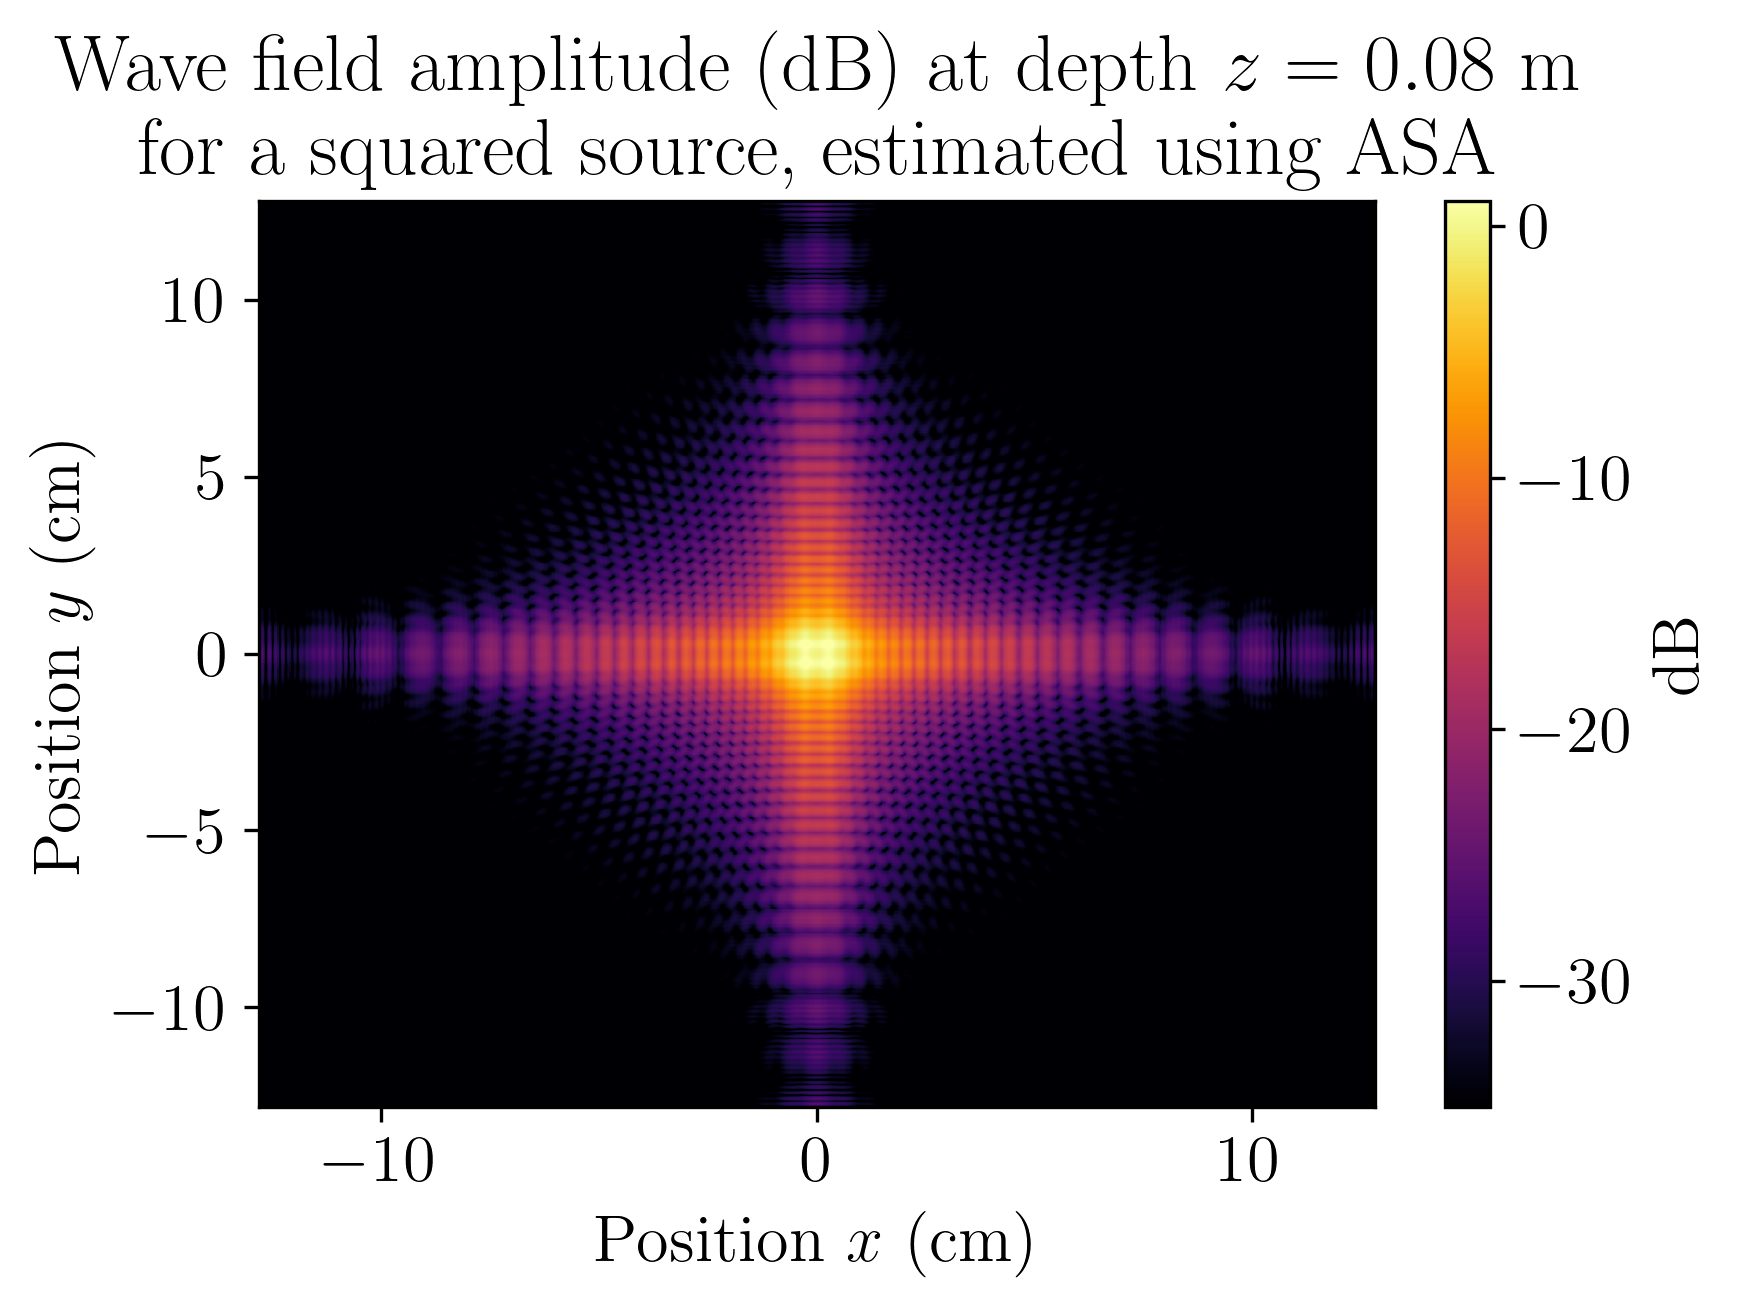

In [147]:
plt.pcolormesh(config['ax']*1e2,config['ay']*1e2,10*np.log10(np.abs(U_mod)),cmap='inferno',shading='auto')
plt.clim(-35,1)
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Position $y$ (cm)')
plt.title('Wave field amplitude (dB) at depth $z=0.08$ m \n for a squared source, estimated using ASA')
c = plt.colorbar()
c.set_label('dB')
plt.savefig('images/ASA/squared/wave_field_2D_z=8cm_squared_smoothed.png',dpi=300)

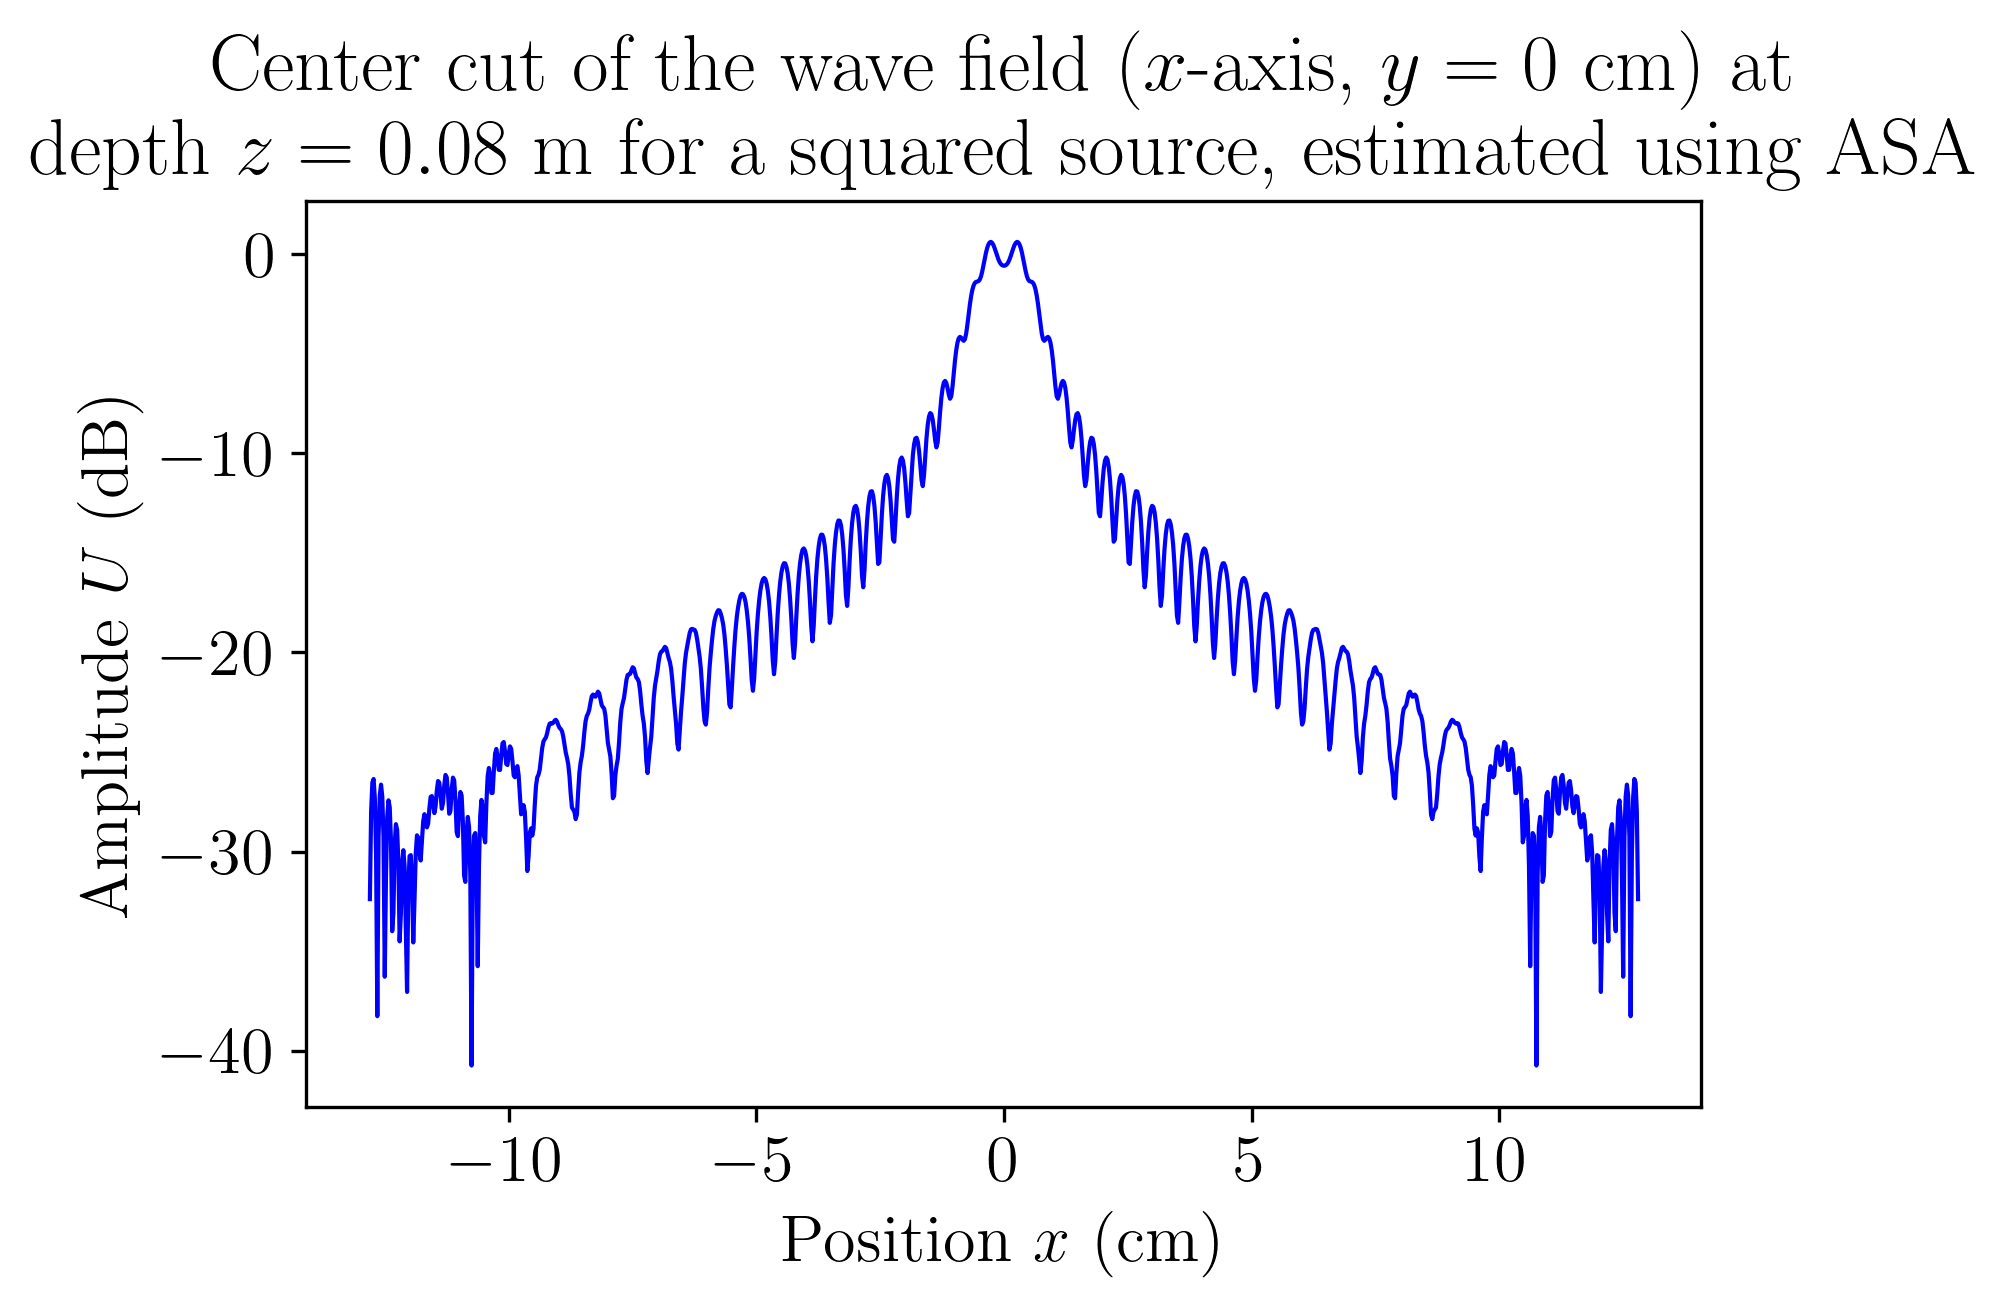

In [148]:
#Plot the center cut of the wave field (as in 1.) at the near-field farfield limit. 
#Describe how you defined this limit.

plt.plot(config['ax']*1e2,10*np.log10(np.abs(U_mod[:,config['Nx']//2])),color='blue',linewidth=1,label='Smoothed aperutre')
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Amplitude $U$ (dB)')
plt.title('Center cut of the wave field ($x$-axis, $y=0$ cm) at \n depth $z=0.08$ m for a squared source, estimated using ASA')
plt.savefig('images/ASA/squared/wave_field_1D_z=8cm_squared_smoothed.png',dpi=300)

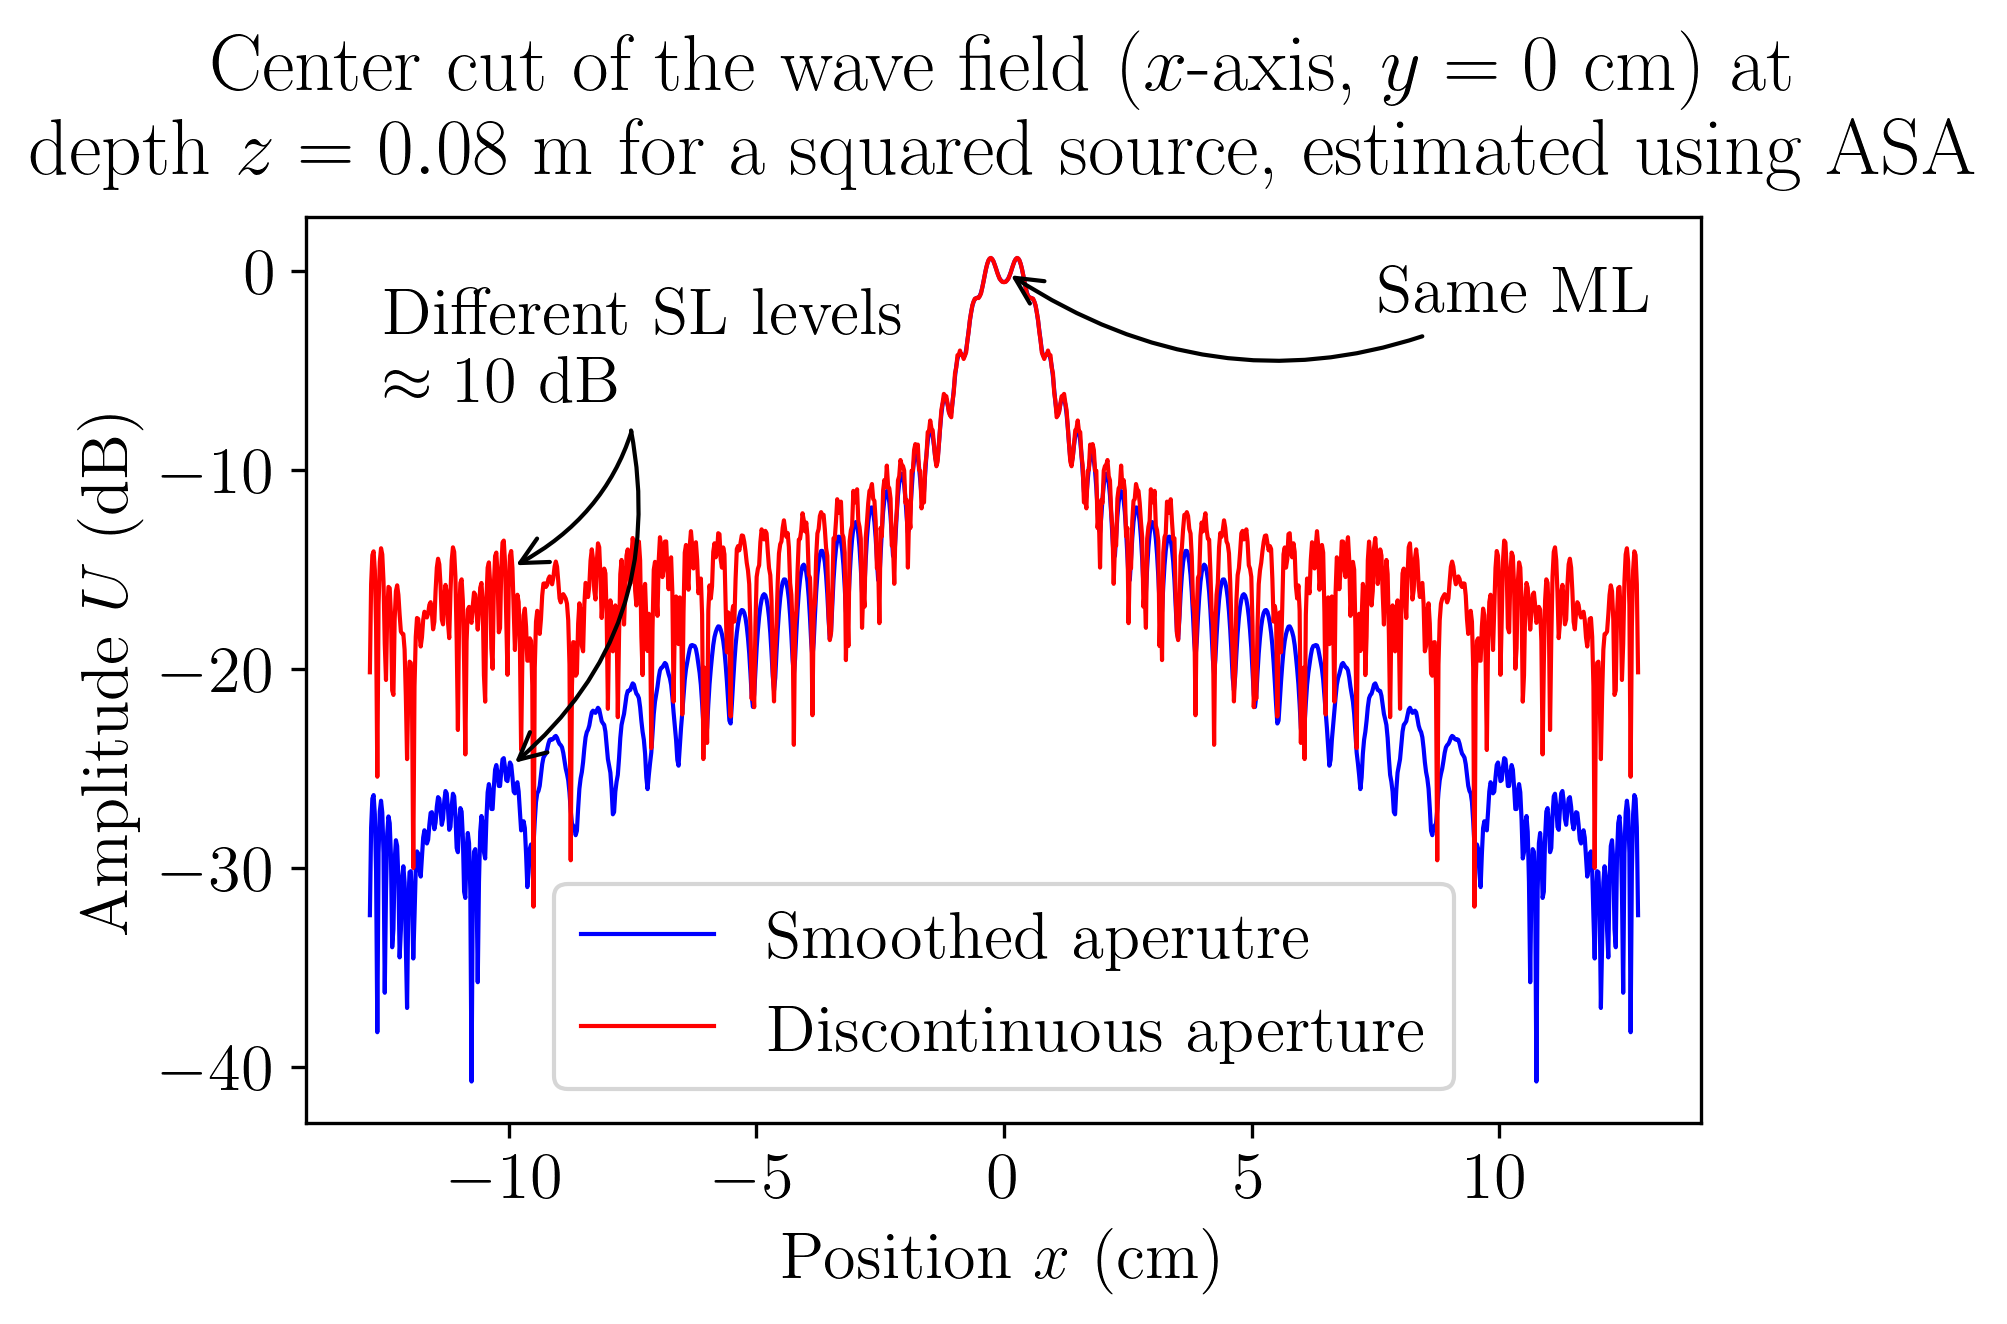

In [253]:
plt.plot(config['ax']*1e2,10*np.log10(np.abs(U_mod[:,config['Nx']//2])),color='blue',linewidth=1,label='Smoothed aperutre')
plt.plot(config['ax']*1e2,10*np.log10(np.abs(U[:,config['Nx']//2])),color='red',linewidth=1,label='Discontinuous aperture')
plt.xlabel('Position $x$ (cm)')
plt.ylabel('Amplitude $U$ (dB)')
plt.legend(loc='best')
plt.title('Center cut of the wave field ($x$-axis, $y=0$ cm) at \n depth $z=0.08$ m for a squared source, estimated using ASA',pad=10)

plt.annotate('Same ML',
         xy=(0, 0), xycoords='data',
         xytext=(+90, -10), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))

plt.annotate('Different SL levels \n $\\approx 10$ dB',
         xy=(-10, -15), xycoords='data',
         xytext=(-30, +40), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))

plt.annotate('',
         xy=(-10, -25), xycoords='data',
         xytext=(29, +83), textcoords='offset points', fontsize=16,
         arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=-.3"))

plt.savefig('images/ASA/squared/wave_field_1D_z=8cm_squared_smoothed_vs_normal.png',dpi=300)

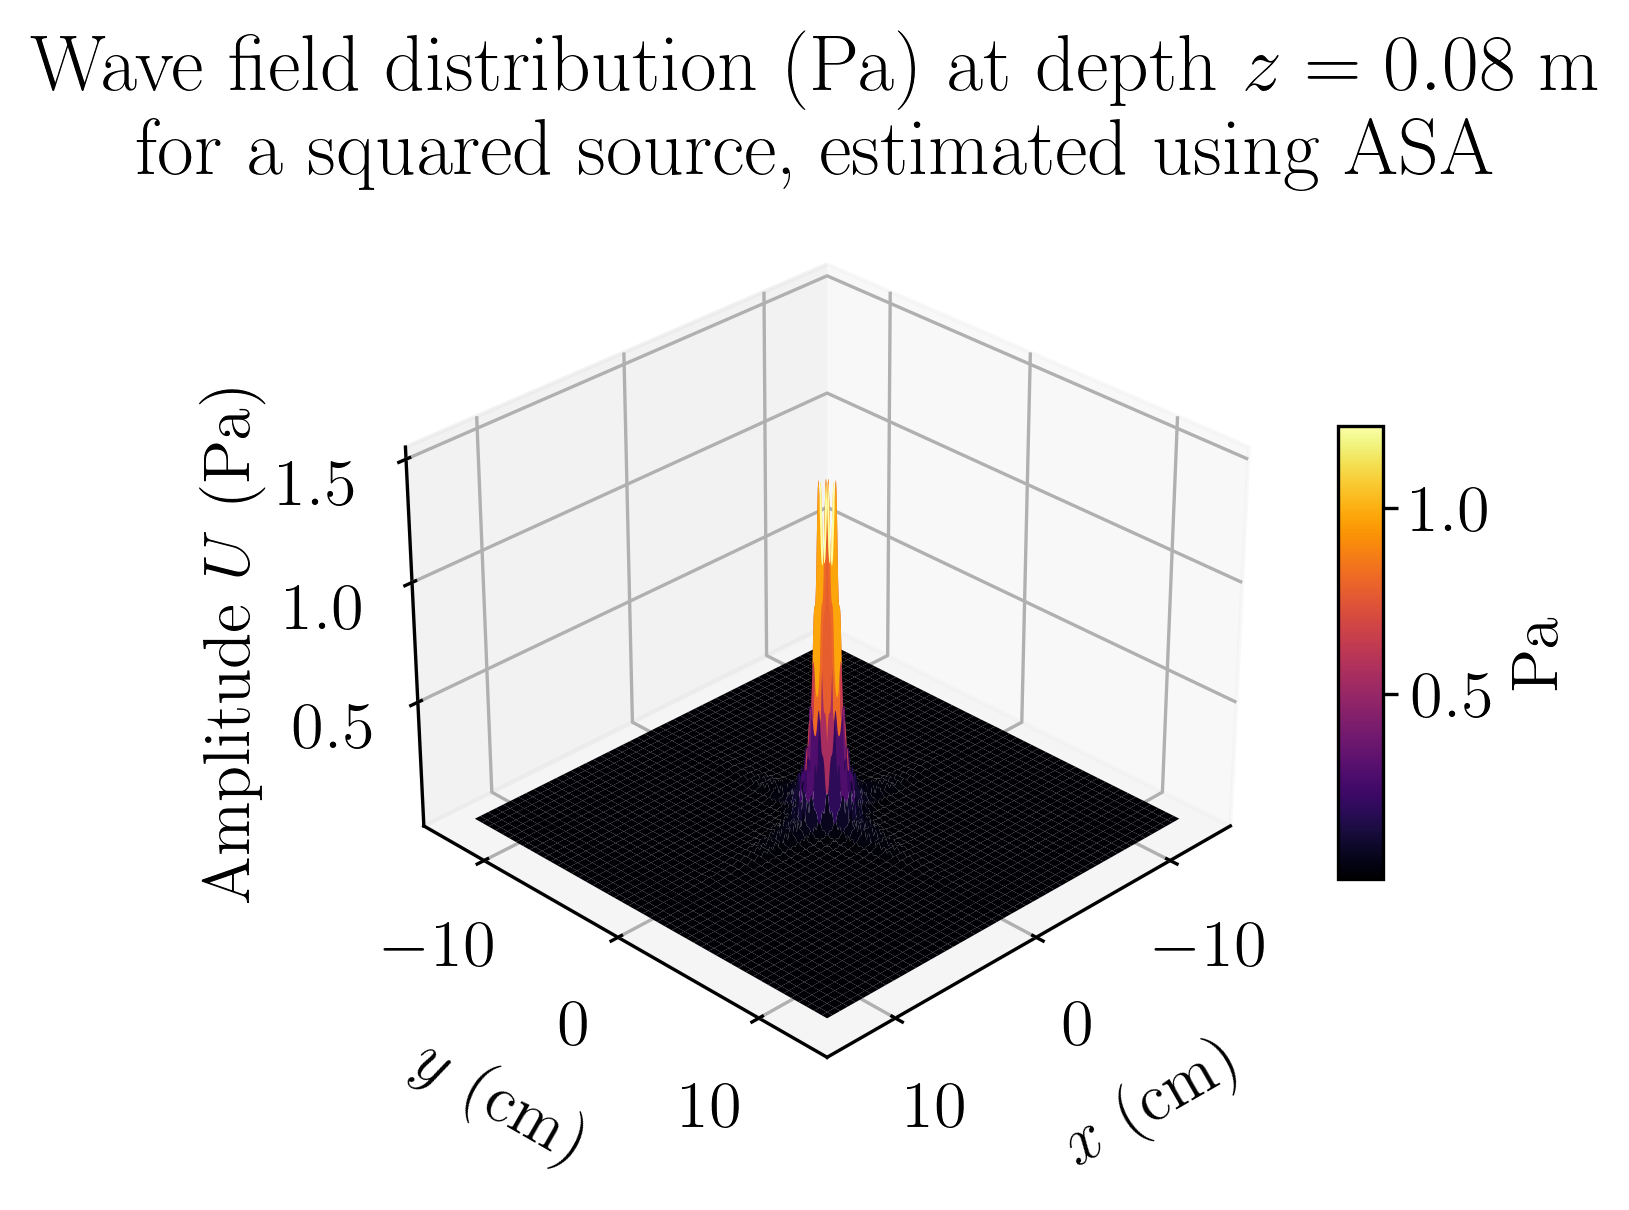

In [150]:
# 3d wave field distribution at the depth z
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X,Y = np.meshgrid(config['ax']*1e2,config['ay']*1e2)
surf = ax.plot_surface(X,Y,np.abs(U_mod), cmap=cm.inferno,linewidth=0, antialiased=True)
ax.view_init(30, 45)
ax.set_xlabel('$x$ (cm)',labelpad=10)
ax.set_ylabel('$y$ (cm)',labelpad=10)
ax.zaxis.set_rotate_label(False)
ax.set_zlabel('Amplitude $U$ (Pa)',rotation=90)
c = fig.colorbar(surf, shrink=0.5, aspect=10)
c.set_label('Pa')
ax.set_title('Wave field distribution (Pa) at depth $z=0.08$ m \n for a squared source, estimated using ASA')
plt.savefig('images/ASA/squared/wave_field_3D_z=8cm_squared_smoothed.png',dpi=300)
plt.show()